<a href="https://colab.research.google.com/github/jakinng/a-PINN/blob/main/neural_operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U neuraloperator # https://github.com/neuraloperator/neuraloperator/tree/main
!pip install wandb
!pip install torch-harmonics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 893.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [4]:
"""
Training a TFNO on Darcy-Flow
=============================

In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package
to train a Tensorized Fourier-Neural Operator
"""

# %%
#

import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
import numpy as np
from neuralop.datasets.data_transforms import DefaultDataProcessor
import jax.numpy as jnp

device = 'cpu'


# # %%
# # Loading the Navier-Stokes dataset in 128x128 resolution
# train_loader_darcy, test_loaders_darcy, data_processor = load_darcy_flow_small(
#         n_train=1000, batch_size=32,
#         test_resolutions=[16, 32], n_tests=[100, 50],
#         test_batch_sizes=[32, 32],
#         positional_encoding=True
# )
data_processor = DefaultDataProcessor()
data_processor = data_processor.to(device)

n_t=10, max_n_t=100
n_t=10, max_n_t=100
(130, 32, 32, 1)
(130, 32, 32)
(130, 1, 32, 32)
(130, 32, 32, 1)
(130, 32, 32)
(130, 1, 32, 32)


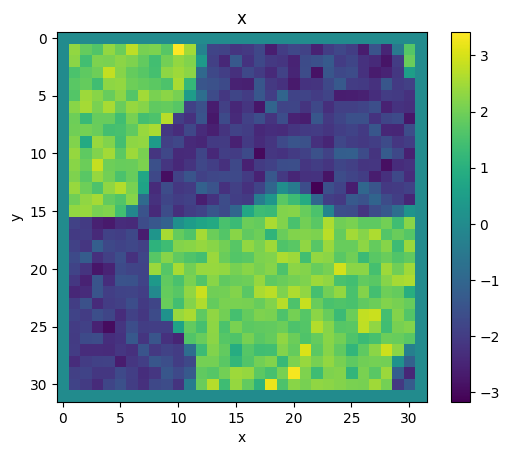

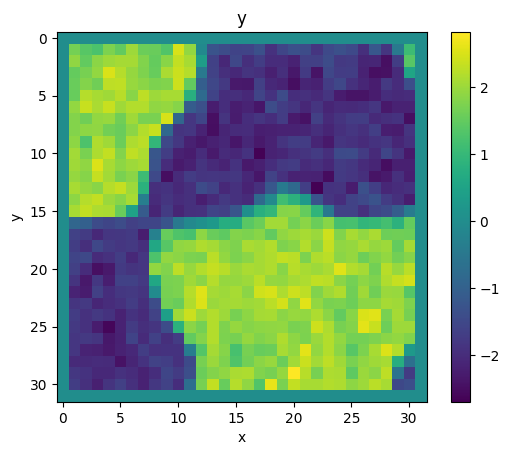

In [ ]:
folder = "/content/drive/MyDrive/superUROP/2024-03-10"
N = 32
def description(i = None):
    if i is None:
        return f"adv-diff_2_dirichlet_32x32_dt0.003_newton"
    else:
        return f"adv-diff_2_dirichlet_32x32_{i}_dt0.003_newton"


"""
Helper function returning a plot of the data
"""
def plot_data(data, title = "", X = None, Y = None, vmin = None, vmax = None, show = False):
    plt.clf()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    vmin = jnp.min(data) if vmin is None else vmin
    vmax = jnp.max(data) if vmax is None else vmax
    # if X is None or Y is None:
    # print(f"imshow! not pcolormesh")
    p = plt.imshow(data, vmin = vmin, vmax = vmax)
    # else:
    #     p = plt.pcolormesh(X, Y, data, vmin = vmin, vmax = vmax)
    plt.colorbar(p)
    if show:
        plt.show()
    return plt

"""
Parameters:
* n_t : number of timesteps to load for each initial condition
* (i_start, i_stop) : load data with initial condition seeds in this range
* show : if True, displays the data as a plot
"""
def load_data(n_t, i_start, i_stop, description, show = False):
    # n_t = 10 # train on each data from an train_initial condition, up to the first n_t timesteps

    # load first data i
    i = i_start
    data = np.load(f"{folder}/{description(i)}.npy")
    max_n_t = data.shape[0]
    initial = np.expand_dims(data[:min(n_t, max_n_t - 1), :, :], axis = -1)
    next = np.expand_dims(data[1 : min(n_t, max_n_t - 1) + 1, :, :], axis = -1)
    print(f"{n_t=}, {max_n_t=}")
    if initial.shape[0] > 0:
        plot_data(initial[0, :, :, 0], show = show, title = "Initial")
        plot_data(next[0, :, :, 0], show = show, title = "Next")
    i += 1

    while i < i_stop:
        data = np.load(f"{folder}/{description(i)}.npy")
        max_n_t = data.shape[0]
        initial_i = np.expand_dims(data[: min(n_t, max_n_t - 1), :, :], axis = -1)
        # print(f"{i}: {initial.shape=}")
        next_i = np.expand_dims(data[1 : min(n_t, max_n_t - 1) + 1, :, :], axis = -1)
        initial = np.concatenate((initial, initial_i), axis = 0)
        next = np.concatenate((next, next_i), axis = 0)
        i += 1
    predict = initial - next
    return initial, predict, next

train_i = (0, 69)
test_i = (70, 83)
initial, predict, next = load_data(10, *train_i, description = description, show = False)

# for i, n in zip(initial, next):
#     plot_data(i, title = "Initial", show = True)
#     plot_data(n, title = "Next", show = True)

# print(initial.shape)
initial = np.squeeze(initial)
# print(initial.shape)
initial = np.expand_dims(initial, axis = 1)
# print(initial.shape)

# print(next.shape)
next = np.squeeze(next)
# print(next.shape)
next = np.expand_dims(next, axis = 1)
# print(next.shape)

X = torch.tensor(initial, dtype = torch.float32)
Y = torch.tensor(next, dtype = torch.float32)
dataset = TensorDataset(X, Y)
# print(dataset[0]['x'].shape)
# loader = DataLoader(list(zip(X, Y)), shuffle=True, batch_size=16)
train_loader = DataLoader(dataset, shuffle=True, batch_size=16)


initial, predict, next = load_data(10, *test_i, description = description, show = False)

print(initial.shape)
initial = np.squeeze(initial)
print(initial.shape)
initial = np.expand_dims(initial, axis = 1)
print(initial.shape)

print(next.shape)
next = np.squeeze(next)
print(next.shape)
next = np.expand_dims(next, axis = 1)
print(next.shape)

X = torch.tensor(initial, dtype = torch.float32)
Y = torch.tensor(next, dtype = torch.float32)
dataset = TensorDataset(X, Y)

# print(dataset[0]['x'].shape)
# print(dataset[0]['y'].shape)

# loader = DataLoader(list(zip(X, Y)), shuffle=True, batch_size=16)
test_loader = DataLoader(dataset, shuffle=True, batch_size=16)
test_loaders = {'32': test_loader, 'train': train_loader}

dataset = train_loader.dataset
for i in range(1):
    for x, y in zip(dataset[i]['x'], dataset[i]['y']):
        plot_data(x.detach().numpy(), title = "x", show = True)
        plot_data(y.detach().numpy(), title = "y", show = True)

# for X_batch, Y_batch in loader:
#     # print(X_batch, y_batch)
#     print(f"{X_batch.shape=}")
#     plot_data(np.squeeze(X_batch.numpy()[0]), "Initial", show = True)
#     plot_data(np.squeeze(Y_batch.numpy()[0]), "Next", show = True)

# print(train_loader)
# print(loader)
# print(train_loader.dataset[0]['x'].shape)
# test_loader = test_loaders['32']
# print(test_loader.dataset[0]['x'].shape)
# print(train_loader_darcy.dataset[0]['x'].shape)



In [ ]:
#@title Trainer

import torch
from torch.cuda import amp
from timeit import default_timer
import pathlib

from neuralop.training.callbacks import PipelineCallback
import neuralop.mpu.comm as comm
from neuralop.losses import LpLoss


class Trainer:
    def __init__(self, *,
                 model,
                 n_epochs,
                 wandb_log=True,
                 device=None,
                 amp_autocast=False,
                 data_processor=None,
                 callbacks = None,
                 log_test_interval=1,
                 log_output=False,
                 use_distributed=False,
                 verbose=False):
        """
        A general Trainer class to train neural-operators on given datasets

        Parameters
        ----------
        model : nn.Module
        n_epochs : int
        wandb_log : bool, default is True
        device : torch.device
        amp_autocast : bool, default is False
        data_processor : class to transform data, default is None
            if not None, data from the loaders is transform first with data_processor.preprocess,
            then after getting an output from the model, that is transformed with data_processor.postprocess.
        log_test_interval : int, default is 1
            how frequently to print updates
        log_output : bool, default is False
            if True, and if wandb_log is also True, log output images to wandb
        use_distributed : bool, default is False
            whether to use DDP
        verbose : bool, default is False
        """

        if callbacks:
            assert type(callbacks) == list, "Callbacks must be a list of Callback objects"
            self.callbacks = PipelineCallback(callbacks=callbacks)
            self.override_load_to_device = (self.callbacks.device_load_callback_idx is not None)
            self.overrides_loss = self.callbacks.overrides_loss
        else:
            self.callbacks = []
            self.override_load_to_device = False
            self.overrides_loss = False

        if verbose:
            print(f"{self.override_load_to_device=}")
            print(f"{self.overrides_loss=}")

        if self.callbacks:
            self.callbacks.on_init_start(model=model,
                 n_epochs=n_epochs,
                 wandb_log=wandb_log,
                 device=device,
                 amp_autocast=amp_autocast,
                 log_test_interval=log_test_interval,
                 log_output=log_output,
                 use_distributed=use_distributed,
                 verbose=verbose)

        self.model = model
        self.n_epochs = n_epochs

        self.wandb_log = wandb_log
        self.log_test_interval = log_test_interval
        self.log_output = log_output
        self.verbose = verbose
        self.use_distributed = use_distributed
        self.device = device
        self.amp_autocast = amp_autocast
        self.data_processor = data_processor

        if self.callbacks:
            self.callbacks.on_init_end(model=model,
                 n_epochs=n_epochs,
                 wandb_log=wandb_log,
                 device=device,
                 amp_autocast=amp_autocast,
                 log_test_interval=log_test_interval,
                 log_output=log_output,
                 use_distributed=use_distributed,
                 verbose=verbose)

    def train(self, train_loader, test_loaders,
            optimizer, scheduler, regularizer,
              training_loss=None, eval_losses=None):

        """Trains the given model on the given datasets.
        params:
        train_loader: torch.utils.data.DataLoader
            training dataloader
        test_loaders: dict[torch.utils.data.DataLoader]
            testing dataloaders
        optimizer: torch.optim.Optimizer
            optimizer to use during training
        optimizer: torch.optim.lr_scheduler
            learning rate scheduler to use during training
        training_loss: training.losses function
            cost function to minimize
        eval_losses: dict[Loss]
            dict of losses to use in self.eval()
        """

        if self.callbacks:
            self.callbacks.on_train_start(train_loader=train_loader, test_loaders=test_loaders,
                                    optimizer=optimizer, scheduler=scheduler,
                                    regularizer=regularizer, training_loss=training_loss,
                                    eval_losses=eval_losses)

        if training_loss is None:
            training_loss = LpLoss(d=2)

        if eval_losses is None: # By default just evaluate on the training loss
            eval_losses = dict(l2=training_loss)

        errors = None

        for epoch in range(self.n_epochs):
            print(f"{epoch=}")
            if self.callbacks:
                self.callbacks.on_epoch_start(epoch=epoch)

            avg_loss = 0
            avg_lasso_loss = 0
            self.model.train()
            t1 = default_timer()
            train_err = 0.0

            for idx, sample in enumerate(train_loader):

                if self.callbacks:
                    self.callbacks.on_batch_start(idx=idx, sample=sample)

                optimizer.zero_grad(set_to_none=True)
                if regularizer:
                    regularizer.reset()

                if self.data_processor is not None:
                    sample = self.data_processor.preprocess(sample)
                else:
                    # load data to device if no preprocessor exists
                    sample = {k:v.to(self.device) for k,v in sample.items() if torch.is_tensor(v)}

                if self.amp_autocast:
                    with amp.autocast(enabled=True):
                        out  = self.model(**sample)
                else:
                    out  = self.model(**sample)

                if self.data_processor is not None:
                    out, sample = self.data_processor.postprocess(out, sample)

                if self.callbacks:
                    self.callbacks.on_before_loss(out=out)

                loss = 0.

                if self.overrides_loss:
                    if isinstance(out, torch.Tensor):
                        loss += self.callbacks.compute_training_loss(out=out.float(), **sample, amp_autocast=self.amp_autocast)
                    elif isinstance(out, dict):
                        loss += self.callbacks.compute_training_loss(**out, **sample, amp_autocast=self.amp_autocast)
                else:
                    if self.amp_autocast:
                        with amp.autocast(enabled=True):
                            if isinstance(out, torch.Tensor):
                                loss = training_loss(out.float(), **sample)
                            elif isinstance(out, dict):
                                loss += training_loss(**out, **sample)
                    else:
                        if isinstance(out, torch.Tensor):
                            loss = training_loss(out.float(), **sample)
                        elif isinstance(out, dict):
                            loss += training_loss(**out, **sample)

                if regularizer:
                    loss += regularizer.loss

                loss.backward()
                del out

                optimizer.step()
                train_err += loss.item()

                with torch.no_grad():
                    avg_loss += loss.item()
                    if regularizer:
                        avg_lasso_loss += regularizer.loss

                if self.callbacks:
                    self.callbacks.on_batch_end()

            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_err)
            else:
                scheduler.step()

            epoch_train_time = default_timer() - t1

            train_err /= len(train_loader)
            avg_loss  /= self.n_epochs
            print(f"{train_err=}")

            if epoch % self.log_test_interval == 0:

                if self.callbacks:
                    self.callbacks.on_before_val(epoch=epoch, train_err=train_err, time=epoch_train_time, \
                                           avg_loss=avg_loss, avg_lasso_loss=avg_lasso_loss)


                for loader_name, loader in test_loaders.items():
                    errors = self.evaluate(eval_losses, loader, log_prefix=loader_name)

                if self.callbacks:
                    self.callbacks.on_val_end()

            if self.callbacks:
                self.callbacks.on_epoch_end(epoch=epoch, train_err=train_err, avg_loss=avg_loss)

        return errors

    def evaluate(self, loss_dict, data_loader,
                 log_prefix=''):
        """Evaluates the model on a dictionary of losses

        Parameters
        ----------
        loss_dict : dict of functions
          each function takes as input a tuple (prediction, ground_truth)
          and returns the corresponding loss
        data_loader : data_loader to evaluate on
        log_prefix : str, default is ''
            if not '', used as prefix in output dictionary

        Returns
        -------
        errors : dict
            dict[f'{log_prefix}_{loss_name}] = loss for loss in loss_dict
        """

        if self.callbacks:
            self.callbacks.on_val_epoch_start(log_prefix=log_prefix, loss_dict = loss_dict, data_loader=data_loader)

        self.model.eval()

        errors = {f'{log_prefix}_{loss_name}':0 for loss_name in loss_dict.keys()}

        n_samples = 0
        with torch.no_grad():
            for idx, sample in enumerate(data_loader):

                n_samples += sample['y'].size(0)
                if self.callbacks:
                    self.callbacks.on_val_batch_start(idx=idx, sample=sample)

                if self.data_processor is not None:
                    sample = self.data_processor.preprocess(sample)
                else:
                    # load data to device if no preprocessor exists
                    sample = {k:v.to(self.device) for k,v in sample.items() if torch.is_tensor(v)}

                out = self.model(**sample)

                if self.data_processor is not None:
                    out, sample = self.data_processor.postprocess(out, sample)

                if self.callbacks:
                    self.callbacks.on_before_val_loss(out=out)

                for loss_name, loss in loss_dict.items():
                    if self.overrides_loss:
                        if isinstance(out, torch.Tensor):
                            val_loss = self.callbacks.compute_training_loss(out.float(), **sample)
                        elif isinstance(out, dict):
                            val_loss = self.callbacks.compute_training_loss(**out, **sample)
                    else:
                        if isinstance(out, torch.Tensor):
                            val_loss = loss(out, **sample)
                        elif isinstance(out, dict):
                            val_loss = loss(out, **sample)
                        if val_loss.shape == ():
                            val_loss = val_loss.item()

                    errors[f'{log_prefix}_{loss_name}'] += val_loss

                if self.callbacks:
                    self.callbacks.on_val_batch_end()

        for key in errors.keys():
            errors[key] /= n_samples

        if self.callbacks:
            self.callbacks.on_val_epoch_end(errors=errors, sample=sample, out=out)

        del out

        return errors

In [ ]:

# %%
# We create a tensorized FNO model

# model = TFNO(in_channels = 1, n_modes=(16, 16), hidden_channels=16, projection_channels=32, factorization='tucker', rank=0.42)
# model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


# %%
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


# %%
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}


# %%

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


# %%
# Create the trainer
trainer = Trainer(model=model, n_epochs=100,
                  device=device,
                  data_processor=None,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)



Our model has 134817 parameters.

### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(16, 16, 16, 9), rank=(13, 13, 13, 7))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOS

In [ ]:
model = torch.load(f"{folder}/model{description()}")

# %%
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


# %%
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}



# %%

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()

# %%
# Create the trainer
trainer = Trainer(model=model, n_epochs=200,
                  device=device,
                  data_processor=None,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

# %%
# uncomment to train
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)
torch.save(trainer.model, f"{folder}/model{description()}")

print(trainer.evaluate(loss_dict=eval_losses,
                 data_loader=train_loader))


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(16, 16, 16, 9), rank=(13, 13, 13, 7))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.losse

Original difference (train): 7.971465587615967
New difference (train): 1.2115057706832886
Original difference (train): 6.1141276359558105
New difference (train): 0.7724984288215637
Original difference (train): 5.091261863708496
New difference (train): 0.5298500657081604
Original difference (test): 10.403830528259277
New difference (test): 1.6179742813110352
Original difference (test): 8.13705062866211
New difference (test): 1.0659641027450562
Original difference (test): 6.7325825691223145
New difference (test): 0.7541200518608093
Original difference (test): 5.769400119781494
New difference (test): 0.5605812668800354
Original difference (test): 5.063083171844482
New difference (test): 0.4243992269039154
Original difference (test): 4.522193908691406
New difference (test): 0.3375413119792938
Original difference (test): 4.0941948890686035
New difference (test): 0.28390008211135864
Original difference (test): 3.7454140186309814
New difference (test): 0.25058579444885254
Original difference 

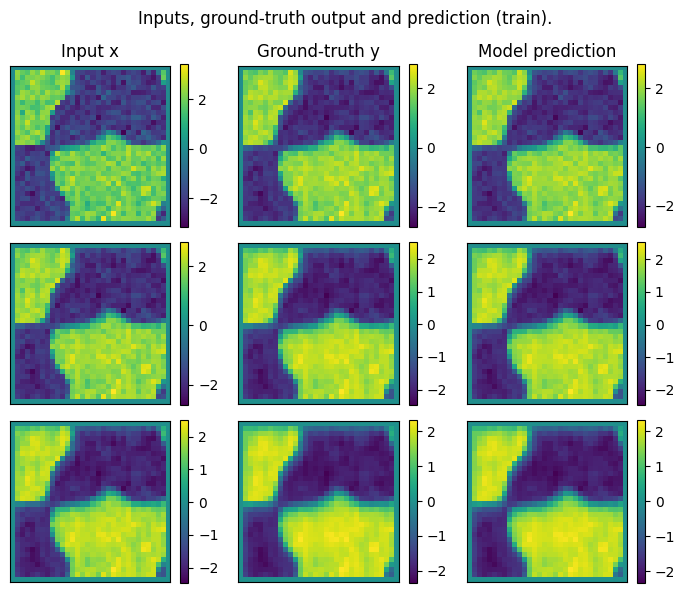

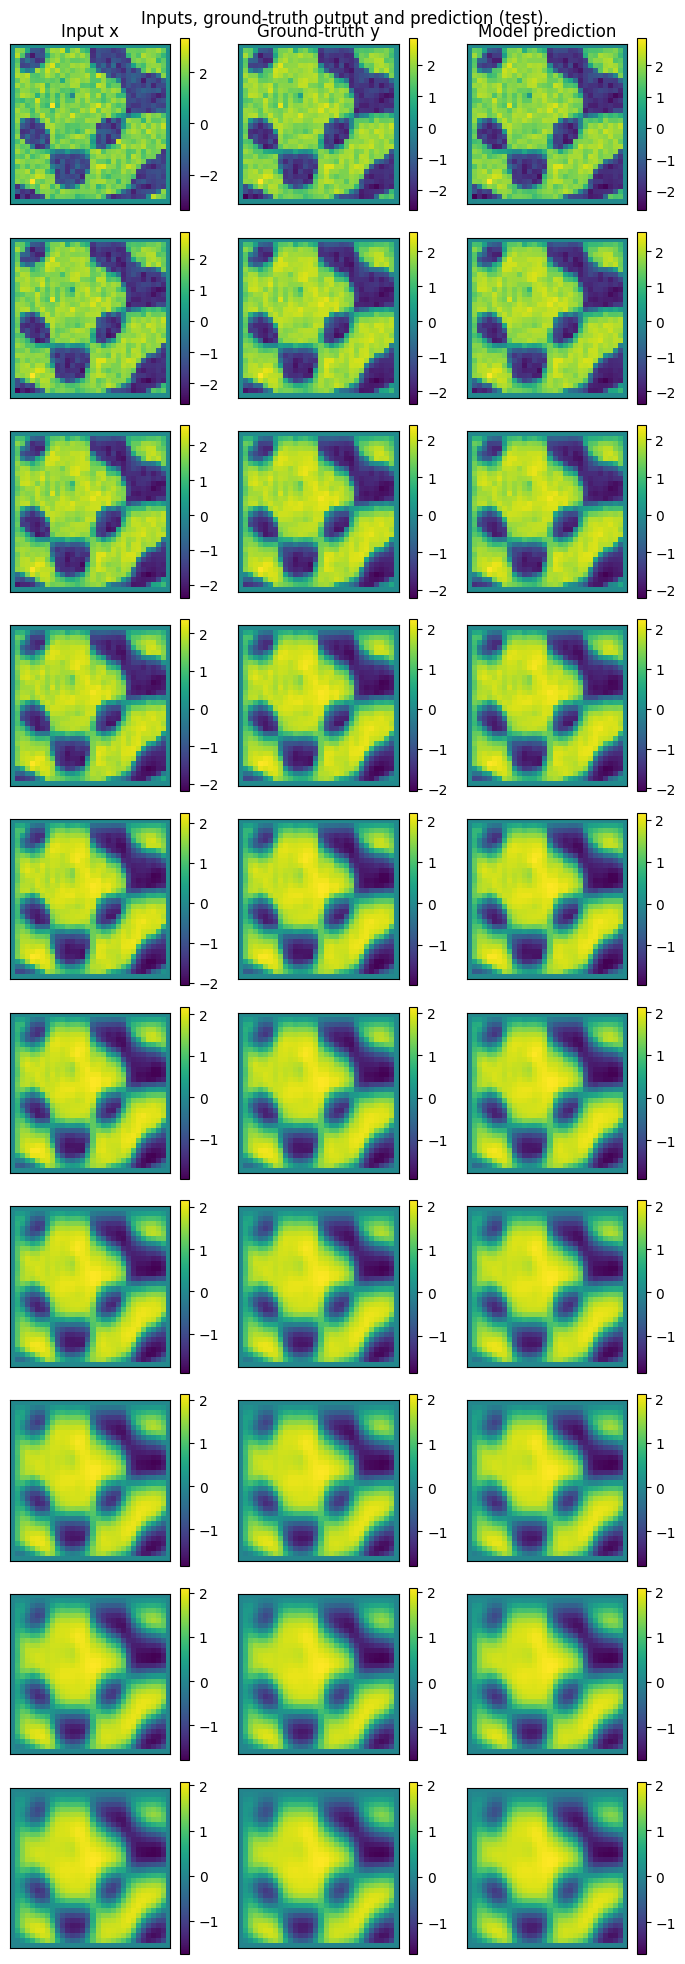

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
import numpy as np
from neuralop.datasets.data_transforms import DefaultDataProcessor
import jax.numpy as jnp

model = torch.load(f"{folder}/model{description()}")
# %%
# Plot the prediction, and compare with the ground-truth
# Note that we trained on a very small resolution for
# a very small number of epochs
# In practice, we would train at larger resolution, on many more samples.
#
# However, for practicity, we created a minimal example that
# i) fits in just a few Mb of memory
# ii) can be trained quickly on CPU
#
# In practice we would train a Neural Operator on one or multiple GPUs

test_samples = test_loaders['train'].dataset
# test_samples = train_loader.dataset

n = 3
fig = plt.figure(figsize=(7, 7 // 3 * n))
for index in range(n):
    data = test_samples[index]
    # print(f"{data=}")
    # data = data_processor.preprocess(data, batched=False)
    # data2 = test_samples[index]
    # print(f"{data['x'].shape=}, {data2['x'].shape=}")
    # plot_data(data['x'].detach().numpy()[0, :, :], "0", show = True)
    # plot_data(data['x'].detach().numpy()[1, :, :], "1", show = True)
    # plot_data(data['x'].detach().numpy()[2, :, :], "2", show = True)
    # plot_data(data2['x'].detach().numpy()[0, :, :], "0 only", show = True)
    # Input x
    x = data['x']
    # print(f"{x}")
    # print(f"{x.shape=}")
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))
    # print(out.shape)

    ax = fig.add_subplot(n, 3, index*3 + 1)
    h = ax.imshow(x[0])#, cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.colorbar(h, ax = ax)
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(n, 3, index*3 + 2)
    h = ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.colorbar(h, ax = ax)
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(n, 3, index*3 + 3)
    h = ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.colorbar(h, ax = ax)
    plt.xticks([], [])
    plt.yticks([], [])
    print(f"Original difference (train): {jnp.linalg.norm(x[0].detach().numpy() - y.detach().numpy())}")
    print(f"New difference (train): {jnp.linalg.norm(out.detach().numpy() - y.detach().numpy())}")

fig.suptitle('Inputs, ground-truth output and prediction (train).')#, y=0.98)
plt.tight_layout()
fig.show()



test_samples = test_loaders['32'].dataset
# test_samples = train_loader.dataset

n = 10
fig = plt.figure(figsize=(7, 7 // 3 * n))
for index in range(n):
    data = test_samples[index]
    # print(f"{data=}")
    # data = data_processor.preprocess(data, batched=False)
    # data2 = test_samples[index]
    # print(f"{data['x'].shape=}, {data2['x'].shape=}")
    # plot_data(data['x'].detach().numpy()[0, :, :], "0", show = True)
    # plot_data(data['x'].detach().numpy()[1, :, :], "1", show = True)
    # plot_data(data['x'].detach().numpy()[2, :, :], "2", show = True)
    # plot_data(data2['x'].detach().numpy()[0, :, :], "0 only", show = True)
    # Input x
    x = data['x']
    # print(f"{x}")
    # print(f"{x.shape=}")
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))
    # print(out.shape)

    ax = fig.add_subplot(n, 3, index*3 + 1)
    h = ax.imshow(x[0])#, cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.colorbar(h, ax = ax)
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(n, 3, index*3 + 2)
    h = ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.colorbar(h, ax = ax)
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(n, 3, index*3 + 3)
    h = ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.colorbar(h, ax = ax)
    plt.xticks([], [])
    plt.yticks([], [])
    print(f"Original difference (test): {jnp.linalg.norm(x[0].detach().numpy() - y.detach().numpy())}")
    print(f"New difference (test): {jnp.linalg.norm(out.detach().numpy() - y.detach().numpy())}")

fig.suptitle('Inputs, ground-truth output and prediction (test).')#, y=0.98)
plt.tight_layout()
fig.show()

In [40]:
#@title Test Times

#@title Newton's Method
# Adapted from https://jax.quantecon.org/newtons_method.html
# https://wiki.math.ntnu.no/_media/tma4125/2017v/newton.pdf

# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import jax
from jax import numpy as jnp
from IPython.display import HTML # display videos

"""
Computes a root of f using Newton's method, with initial guess x_0

Parameters:
* f : the function to find a root of
* x_0 : the initial guess for a root
* max_iter : the maximum number of iterations
"""
def newton(f, x_0, tol = 1e-5, max_iter = 3):
    df = jax.jacfwd(f) # Jacobian of f
    error = jnp.inf
    e_all = jnp.expand_dims(error, axis = 0) # Error for each iteration
    x_all = jnp.expand_dims(x_0, axis = 0) # Value for each iteration
    n_iter = 0
    while error > tol and n_iter < max_iter:
        n_iter += 1
        x = x_all[n_iter - 1]
        dfx = df(x)
        # print(f"{jnp.linalg.matrix_rank(dfx)=}")
        if dfx.shape == (): # The problem is 1-dimensional
            # x_n = x - jnp.linalg.lstsq(jnp.array(dfx).reshape(1, 1), jnp.array(f(x)).reshape(1, ))[0]
            x_all = jnp.append(x_all, jnp.expand_dims((x - f(x) / dfx), axis = 0), axis = 0) # Newton iteration
        else:
            # x_n = x - jnp.linalg.pinv(df(x)) @ f(x)
            # x_n = x - jnp.linalg.solve(df(x), f(x))
            # print(f"{jnp.linalg.lstsq(dfx, f(x))[0]=}")
            x_n = x - jnp.linalg.lstsq(dfx, f(x))[0] # x_n = x - JF(x)^{-1}f(x)
            x_all = jnp.append(x_all, x_n[None, :], axis = 0)
        error = jnp.linalg.norm(x_all[n_iter] - x_all[n_iter - 1]) / jnp.linalg.norm(x_all[n_iter - 1])
        # error = jnp.linalg.norm(f(x_all[n_iter]))
        print(f"{error=}")
        e_all = jnp.append(e_all, jnp.expand_dims(error, axis = 0), axis = 0)
    return x_all, n_iter, e_all


def newton_parareal(f, x_0, tol = 1e-5, max_iter = 3):
    df = jax.jacfwd(f) # Jacobian of f
    error = jnp.inf
    N = x_0.shape[0]
    e_all = jnp.zeros(shape = (max_iter, 1))
    x_all = jnp.zeros(shape = (max_iter, N))
    e_all = e_all.at[0].set(error)
    x_all = x_all.at[0].set(x_0)
    n_iter = 0

    init_val = (x_all, n_iter, e_all, tol, max_iter)
    def cond_fun(val):
        x_all, n_iter, e_all, tol, max_iter = val
        error = e_all[n_iter]
        # print(f"{jnp.all(error > tol)}")
        # return jnp.all(error > tol) and n_iter < max_iter
        return jnp.all(jnp.logical_and(n_iter < max_iter, error > tol))

    def body_fun(val):
        x_all, n_iter, e_all, tol, max_iter = val
        n_iter += 1
        x = x_all[n_iter - 1]
        dfx = df(x)
        x_n = x - jnp.linalg.lstsq(dfx, f(x))[0] # x_n = x - JF(x)^{-1}f(x)
        x_all = x_all.at[n_iter].set(x_n)
        error = jnp.linalg.norm(x_all[n_iter] - x_all[n_iter - 1]) / jnp.linalg.norm(x_all[n_iter - 1])
        e_all = e_all.at[n_iter].set(error)
        return x_all, n_iter, e_all, tol, max_iter
    val = init_val
    # while cond_fun(val):
    #     val = body_fun(val)
    # x_all, n_iter, e_all, tol, max_iter = val
    # return x_all, n_iter, e_all
    x_all, n_iter, e_all, tol, max_iter = jax.lax.while_loop(cond_fun, body_fun, init_val)

    return x_all, n_iter, e_all
def plot_data(data, title = "", X = None, Y = None, vmin = None, vmax = None, show = False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    vmin = jnp.min(data) if vmin is None else vmin
    vmax = jnp.max(data) if vmax is None else vmax
    if X is None or Y is None:
        p = ax.pcolormesh(data, vmin = vmin, vmax = vmax)
    else:
        p = ax.pcolormesh(X, Y, data, vmin = vmin, vmax = vmax)
    cbar = plt.colorbar(p, ax = ax)
    if show:
        plt.show()
    return fig, plt, p

class Solver():
    def __init__(self, N, N_t, dt, bounds, seed, ic, bc, folder = "/content/drive/MyDrive/superUROP", equation = "adv-diff", initializer = None, parareal_iters = 1):
        self.N = N
        self.N_t = N_t
        self.dt = dt
        self.bounds = bounds
        self.L, self.dx, self.x, self.y, self.X, self.Y = self.domain(N, bounds)
        self.seed = seed
        self.key = jax.random.PRNGKey(seed)
        self.u = self.initial_condition(ic, bc)
        self.ic = ic
        self.bc = bc
        self.folder = folder
        self.equation = equation
        self.test_name = self.test_name(equation)
        self.initializer = lambda x: x.flatten() if initializer is None else initializer
        self.parareal_iters = parareal_iters

    """
    Helper function returning a plot of the data
    """
    def plot_data(self, data, title = "", X = None, Y = None, vmin = None, vmax = None, show = False):
        return plot_data(data, title = title, X = self.X, Y = self.Y, show = show)

    """
    Helper function returning u with the boundaries set to 0
    """
    def dirichlet(self, u):
        u_top = 0.0
        u_left = 0.0
        u_bottom = 0.0
        u_right = 0.0
        u = u.at[-1, :].set(u_top)
        u = u.at[0, :].set(u_bottom)
        u = u.at[:, 0].set(u_left)
        u = u.at[:, -1].set(u_right)
        return u

    def diffusion_coefficient(self, u):
        # x_reshape = x.reshape(self.N, self.N)
        grad_y, grad_x = jnp.gradient(u)
        grad_norm2 = jnp.linalg.norm(jnp.array([grad_x, grad_y]), axis = 0) ** 2 # Norm-squared of the gradient of solution
        d = jnp.exp(-1 * grad_norm2) # Diffusion coefficient
        # min = jnp.min(d)
        # max = jnp.max(d)
        # return 0
        return d # / 30

    def advection_velocity(self):
        v_x = 5
        v_y = 20
        return v_x, v_y

    def test_name(self, equation):
        return f"{equation}_{self.ic}_{self.bc}_{self.N}x{self.N}_{self.seed}_dt{self.dt}"

    def domain(self, N, bounds):
        L = bounds[1] - bounds[0]
        x = jnp.linspace(bounds[0], bounds[1], N, endpoint = False)
        y = jnp.linspace(bounds[0], bounds[1], N, endpoint = False)
        X, Y = jnp.meshgrid(x, y)
        dx = L / N
        return L, dx, x, y, X, Y

    def initial_condition(self, ic, bc):
        # Initialize the solution grid of u(k, i, j)
        u = jnp.zeros((self.N_t, self.N, self.N))
        noise = jax.random.normal(key = self.key, shape = u[0].shape) # Gaussian noise
        # Set the initial condition
        if ic == 1:
            u = u.at[0, self.N // 4 : 3 * self.N // 4, self.N // 4 : 3 * self.N // 4].set(1)
            noise_level = 0.1

        elif ic == 2:
            coeffs = jax.random.normal(key = self.key, shape = (5, 3))
            def poly(x, y):
                omegas = jnp.geomspace(0.5, 2, coeffs.shape[0])
                return jnp.sum(coeffs[:, 0] * jnp.cos(x * omegas + coeffs[:, 1]) * jnp.cos(y * omegas + coeffs[:, 2]))
            v = jax.vmap(jax.vmap(poly))(self.X, self.Y)
            scale = 2
            v = scale * (2 * v - jnp.min(v) - jnp.max(v)) / (jnp.max(v) - jnp.min(v)) # rescale to range -10 to 10

            # clip at threshold and rescale to (-1, 1)
            threshold = 20
            v = jnp.clip(threshold * v, -scale, scale)
            u = u.at[0].set(v)

            # add noise so DF is not NAN
            noise_level = 0.4
        elif ic == 3:
            u = u.at[0, :, :].set(100 * (1 - ((self.X - jnp.pi) / jnp.pi) ** 2) * (1 - ((self.Y - jnp.pi) / jnp.pi) ** 2))
            noise_level = 10

        elif ic == 4:
            u = u.at[0].set(jnp.exp(- ((self.X - (self.bounds[1] - self.bounds[0]) / 2) ** 2 + (self.Y - (self.bounds[1] - self.bounds[0]) / 2) ** 2)))
            noise_level = 0.1

        # Set the boundary conditions
        u = u.at[0].set(u[0] + noise_level * noise)
        match bc:
            case "dirichlet":
                u = u.at[0].set(self.dirichlet(u[0]))
            case "neumann":
                u = u.at[0, (self.N - 1):, :].set(u[0, self.N - 2 : self.N - 1, :])
                u = u.at[0, :, :1].set(u[0, :, 1:2])
                u = u.at[0, :1, :].set(u[0, 1:2, :])
                u = u.at[0, :, (self.N - 1):].set(u[0, :, self.N - 2:self.N - 1])
            case "torus":
                pass
        return u

    def F(self, u):
        u = u.reshape(self.N, self.N)

        v_x, v_y = self.advection_velocity()
        if v_x > 0:
            # Dirichlet boundary conditions
            # Multiply by velocity (https://iopscience.iop.org/article/10.1088/1742-6596/1180/1/012009/pdf)
            pad_x = jnp.pad(u * v_x, pad_width = ((0, 0), (1, 0)))
        elif v_x <= 0:
            pad_x = jnp.pad(u * v_x, pad_width = ((0, 0), (0, 1))) # Dirichlet boundary conditions
        if v_y > 0:
            pad_y = jnp.pad(u * v_y, pad_width = ((1, 0), (0, 0)))
        elif v_y <= 0:
            pad_y = jnp.pad(u * v_y, pad_width = ((0, 1), (0, 0)))
        grad_vx = (pad_x[:, 1:] - pad_x[:, :-1]) / self.dx
        grad_vy = (pad_y[1:, :] - pad_y[:-1, :]) / self.dx
        op = -1 * (grad_vx + grad_vy)

        d = self.diffusion_coefficient(u)
        lap_kernel = 1 / (self.dx ** 2) * jnp.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        op += d * 1 * jax.scipy.signal.convolve2d(u, lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)
        if self.bc == "dirichlet":
            # Set boundaries to zero
            op = self.dirichlet(op)
        return op.flatten()
        # elif self.bc == "torus":
        #         op = d * self.dt * jax.scipy.signal.convolve2d(x_reshape, lap_kernel, mode = "same", boundary = "wrap", fillvalue = 0)

    def finite_difference(self, diffusion_coefficient = None):
        v_x, v_y = self.advection_velocity()
        C = jnp.abs(v_x * self.dt / self.dx) + jnp.abs(v_y * self.dt / self.dx)
        print(f"The Courant number at x = 0, y = 0 is {C}. Stable if C <= 1.")
        for k in range(self.N_t - 1):
            op = self.F(self.u[k]).reshape(self.N, self.N)
            self.u = self.u.at[k + 1].set(self.u[k] + dt * op) # Add delta u term
            self.u = self.u.at[k + 1].set(self.dirichlet(self.u[k + 1]))
        filename = f"{self.folder}/{self.test_name}"
        jnp.save(filename, self.u)
        # self.test_name += "finite_diff"

    def backward_euler(self, max_newton_iter = 5):
        n_iters = []
        e_alls = []
        for k in range(self.N_t - 1):
            x_0 = initializer(self.u[k])
            # Find root x satisfying x - u[k] = dt * (op(x)) and set it to be u[k + 1]
            x_all, n_iter, e_all = newton(f = lambda x: x - x_0 - self.dt * self.F(x), x_0 = x_0, max_iter = max_newton_iter)
            print(f"{e_all=}")
            self.u = self.u.at[k + 1].set(x_all[-1].reshape(self.N, self.N))
            n_iters.append(n_iter)
            e_alls.append(e_all)
        jnp.save(f"{self.folder}/{self.test_name}_newton", self.u)
        # self.test_name += "newton"
        return n_iters, e_alls

    def parareal(self, predict, max_newton_iter = 10):
        previous_G = jnp.copy(self.u)
        new_G = jnp.copy(self.u)

        NG = 10
        # Coarse integrator
        for k in range(0, self.N_t - NG, NG):
            self.u = self.u.at[k + NG].set(predict(self.u[k]).reshape(self.N, self.N))
            previous_G = previous_G.at[k + NG].set(self.u[k + NG])

        # for i in range(self.N_t):
        #     self.plot_data(self.u[i], title = f"{i}", show = True)

        def fine_solver(x_0): #start_index):#, stop_index):
            # stop_index = start_index + NG - 1 # start_index = 0, stop_index = 4
            fine_u = jnp.zeros(shape = (NG + 1, self.N, self.N))
            fine_u = fine_u.at[0].set(x_0.reshape(self.N, self.N))
            x_0 = x_0.flatten()
            for j in range(NG): #start_index, stop_index, 1): # j = 0, 1, 2, 3, 3
                # x_0 = self.u[j].flatten()
                x_all, n_iter, e_all = newton_parareal(f = lambda x: x - x_0 - self.dt * self.F(x), x_0 = x_0, max_iter = max_newton_iter)
                x_0 = x_all[n_iter]
                fine_u = fine_u.at[j + 1].set(x_0.reshape(self.N, self.N))
                x_0 = x_0.flatten()
                # self.u = self.u.at[j + 1].set(x_all[-1].reshape(self.N, self.N))
            return fine_u

        err = 0
        fine_solver_parallel = jax.vmap(fine_solver)
        while err < self.parareal_iters:
            start_idxs = jnp.arange(0, self.N_t, NG)
            print(f"{start_idxs=}, {err=}")
            start_x0s = []
            for i in start_idxs:
                self.plot_data(self.u[i], title = f"start idx {i}", show = True)
                start_x0s.append(self.u[i].flatten())
                plt.close()
            # self.plot_data(start_x0s[1].reshape(self.N, self.N), show = True)
            fine_us = fine_solver_parallel(jnp.array(start_x0s))

            print(fine_us.shape)
            for i in range(self.N_t // NG):
            # for i in start_idxs:
                for j in range(1, NG + 1):
                    if i + j < self.N_t:
                        self.u = self.u.at[i * NG + j].set(fine_us[i][j])
                        print(f"at time {i * NG + j}")
                        self.plot_data(self.u[i * NG + j], title = f"at idx {i * NG + j}", show = True)
                        plt.close()

            for k in range(0, self.N_t - NG, NG):
                print(f"{k=}, {k + NG=}")
                self.plot_data(self.u[k], title = "new u", show = True)
                new_G = new_G.at[k + NG].set(predict(self.u[k]).reshape(self.N, self.N))
                self.plot_data(new_G[k + NG] - previous_G[k + NG], title = "diff", show = True)
                plt.close()

            for k in range(0, self.N_t - NG, NG):
                print(f"{k=}, {k + NG=}")
                self.plot_data(self.u[k + NG], title = "before update", show = True)
                self.u = self.u.at[k + NG].add(new_G[k + NG] - previous_G[k + NG])
                self.plot_data(new_G[k + NG], title = "new_G", show = True)
                self.plot_data(previous_G[k + NG], title = "previous_G", show = True)
                self.plot_data(self.u[k + NG], title = "after update", show = True)
                plt.close()

            previous_G = jnp.copy(new_G)
            err += 1
            print(f"{err=}")
        jnp.save(f"{self.folder}/{self.parareal_iters}pararealiter_{self.test_name}", self.u)
        # self.test_name += "_parareal"

    def animate_solution(self, u, description = "", folder = None, test_name = None):
        folder = self.folder if folder is None else folder
        test_name = self.test_name if test_name is None else test_name
        fig, plt, p = self.plot_data(u[0], title = f"Solution at t = {0 * self.dt:.3f}", vmin = jnp.min(u), vmax = jnp.max(u))

        def animate(k):
            p.set_array(u[k])
            p.set_clim(jnp.min(u), jnp.max(u))
            plt.title(f"Solution at t = {k * self.dt:.3f}")

        anim = animation.FuncAnimation(fig, animate, frames = self.N_t, repeat=False)
        FFwriter = animation.FFMpegWriter(fps = 10)
        anim.save(f"{folder}/{self.parareal_iters}pararealiter_{test_name}.mp4", writer = FFwriter, dpi = 300)
        return anim


k=0, k + NG=10
k=10, k + NG=20
k=20, k + NG=30
k=30, k + NG=40
k=40, k + NG=50
k=50, k + NG=60
k=60, k + NG=70
k=70, k + NG=80
k=80, k + NG=90
k=90, k + NG=100


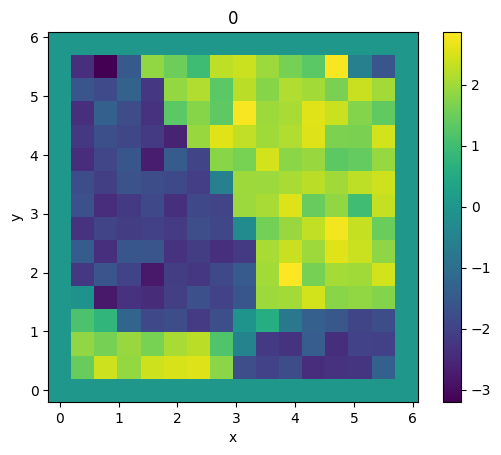

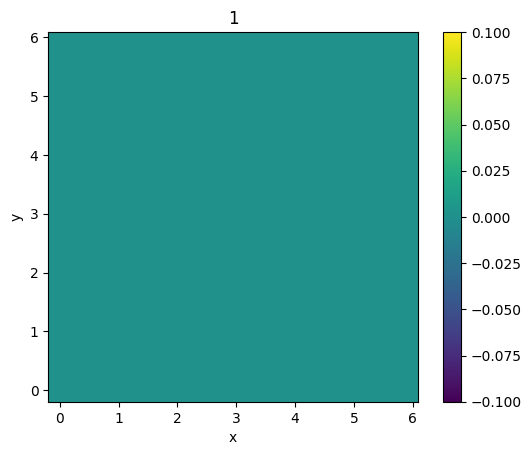

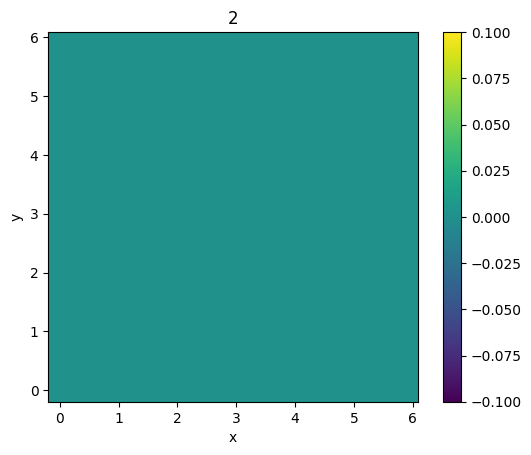

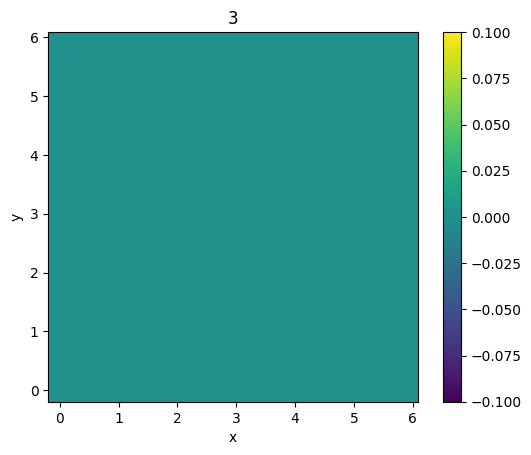

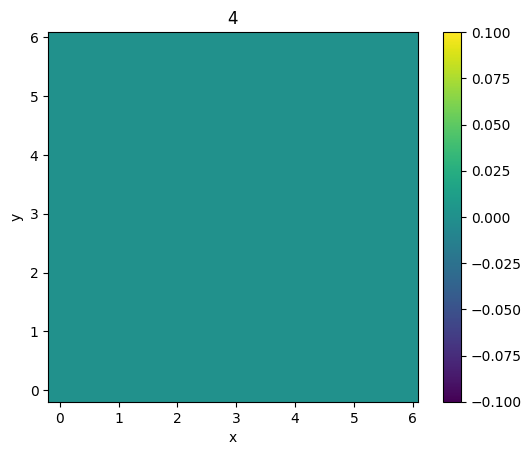

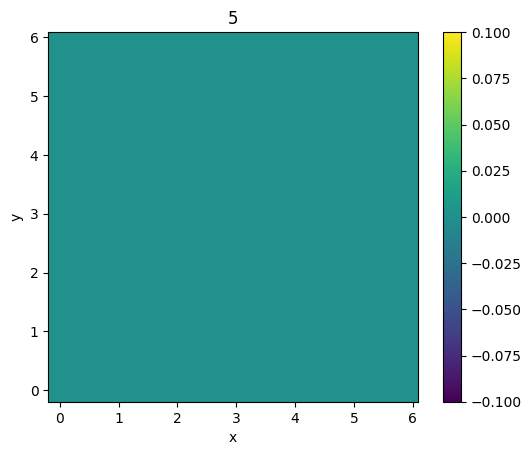

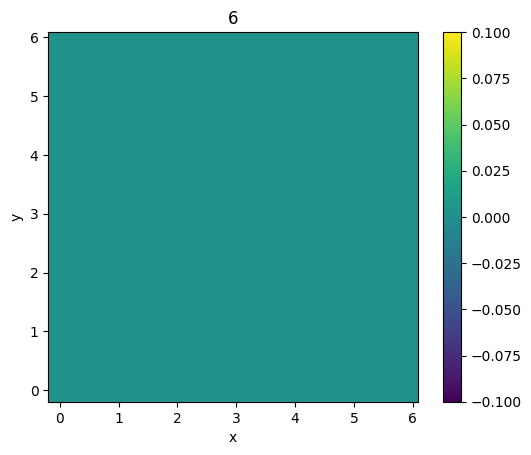

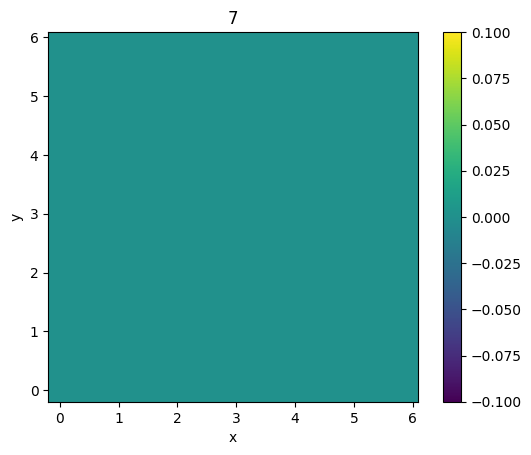

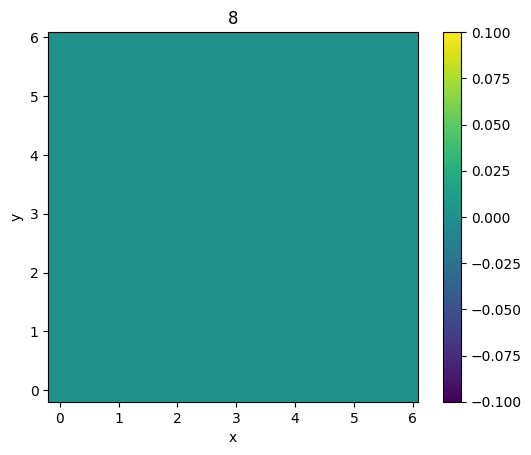

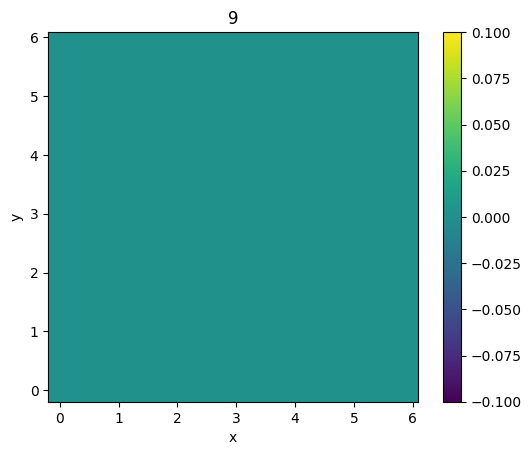

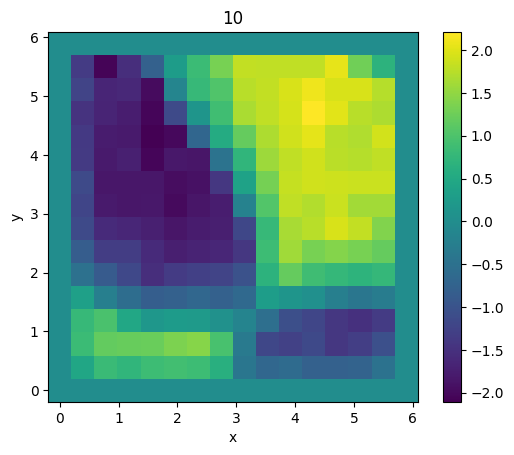

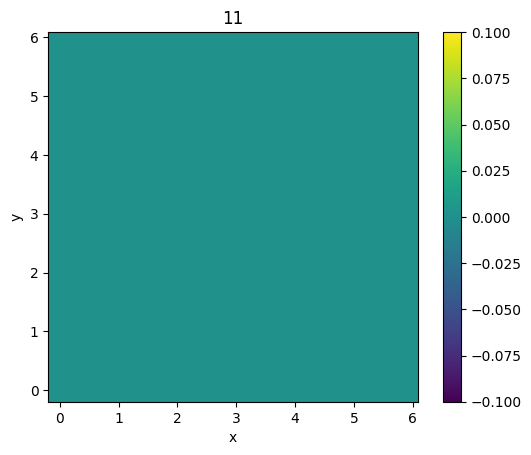

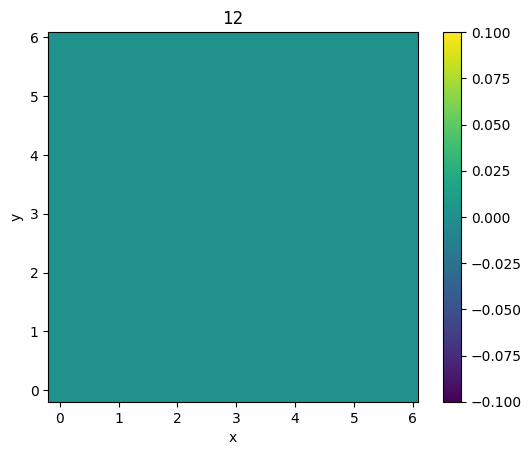

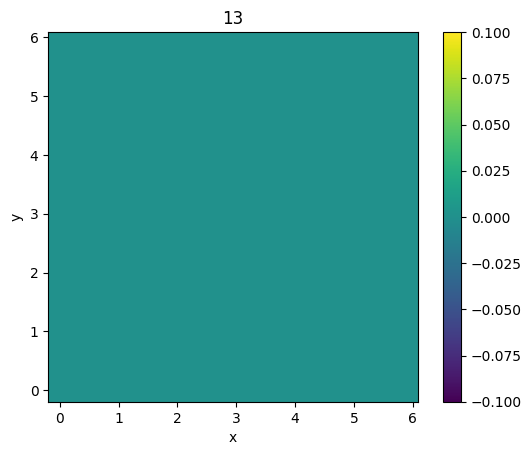

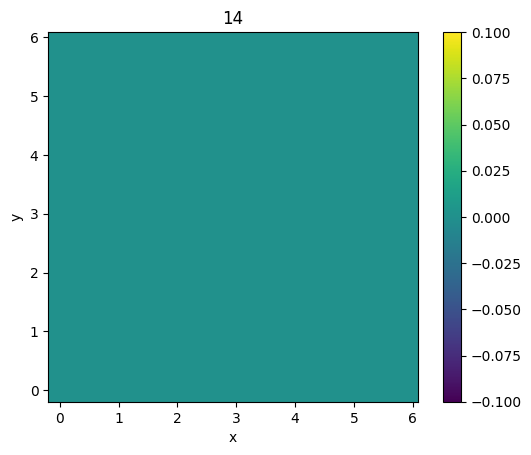

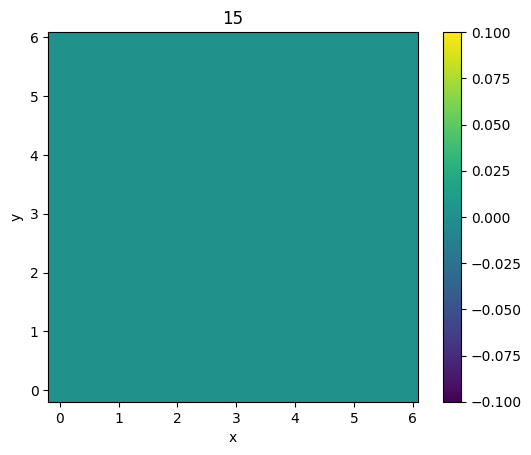

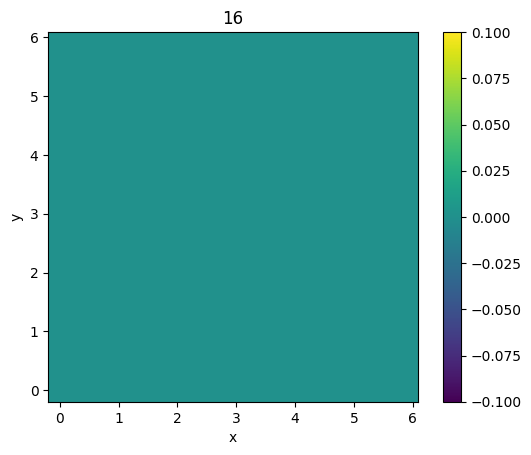

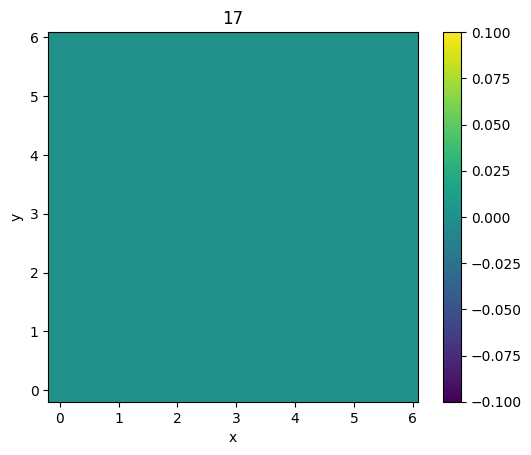

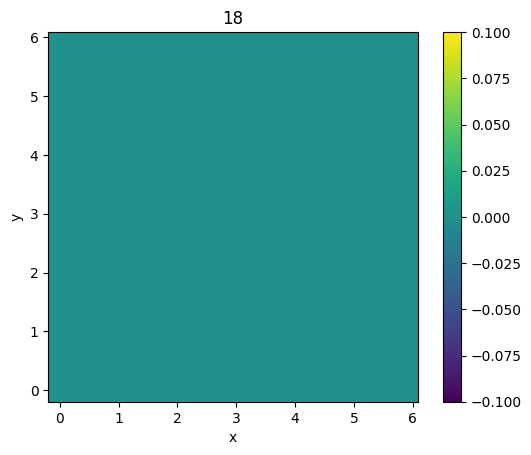

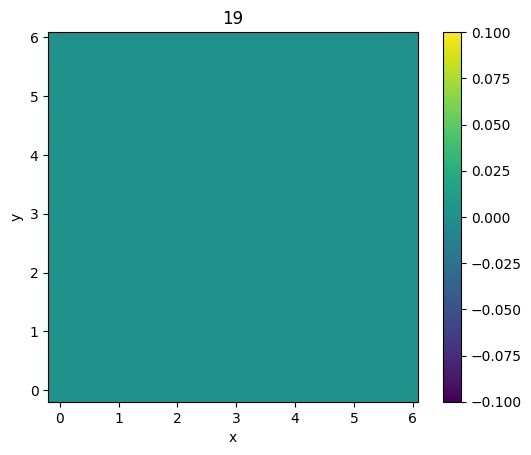

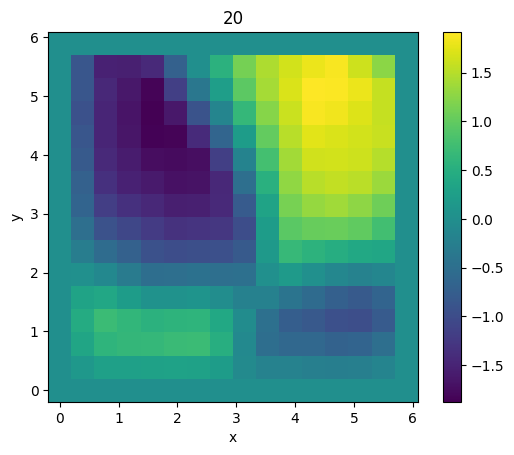

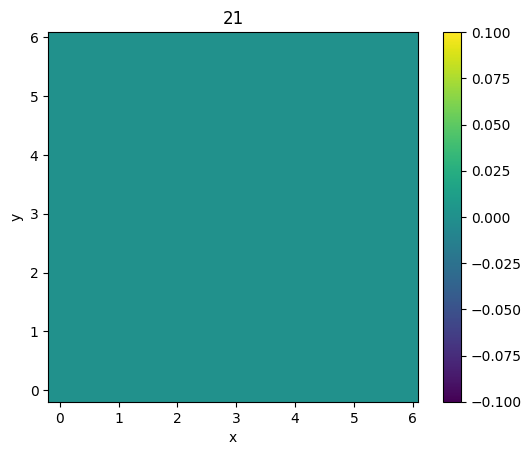

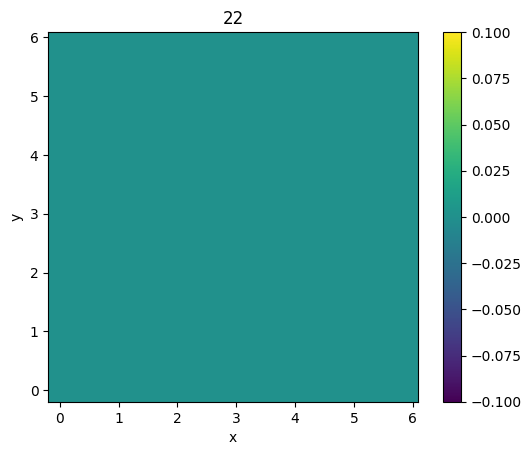

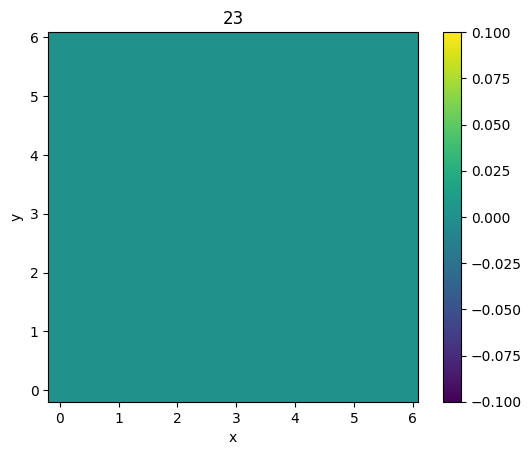

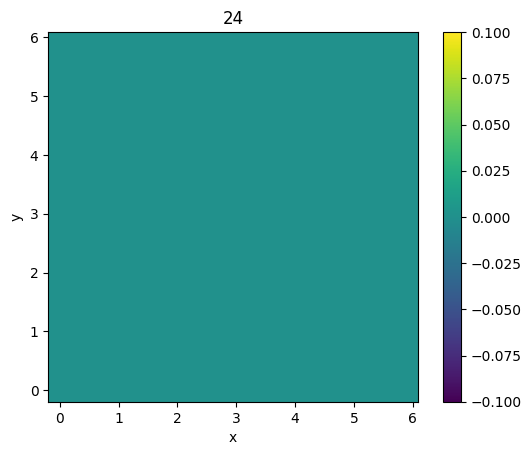

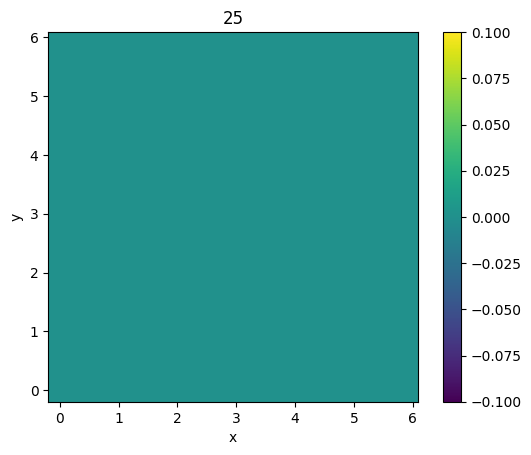

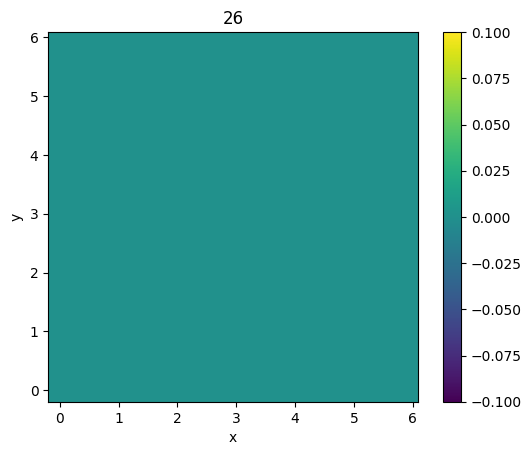

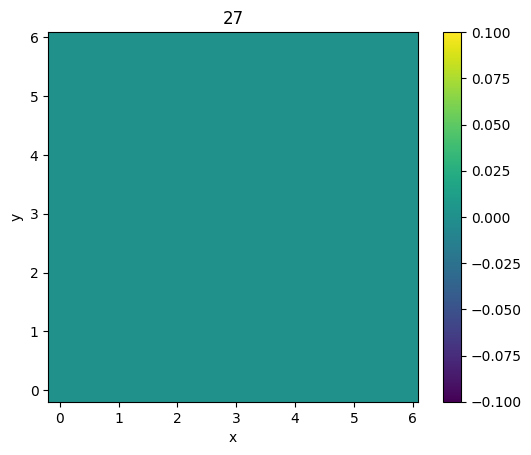

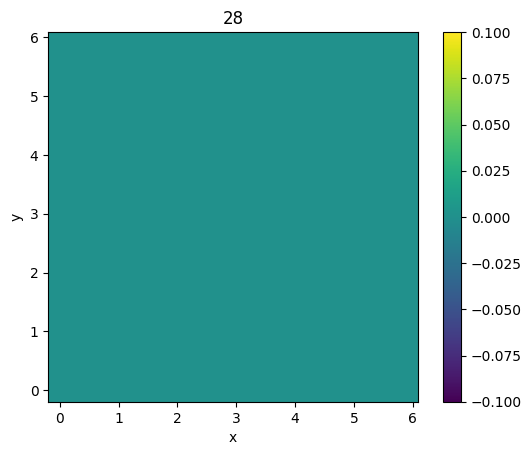

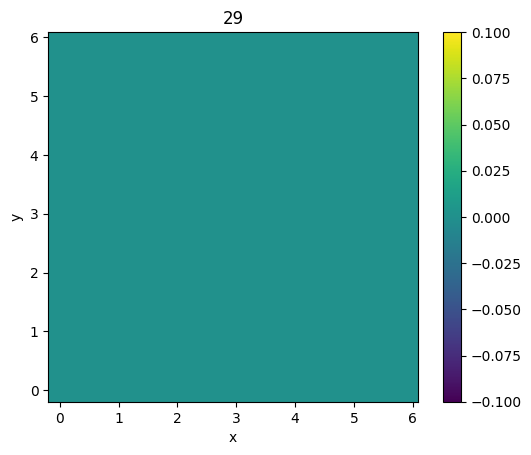

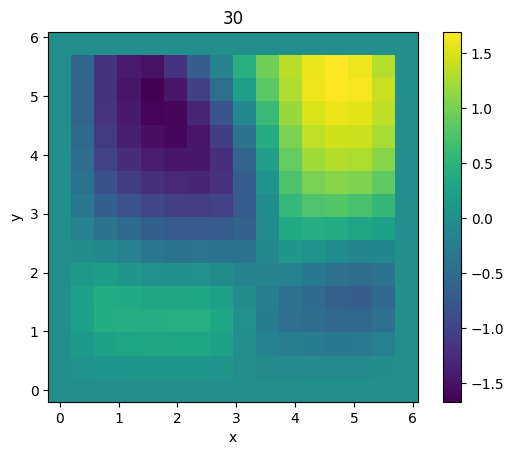

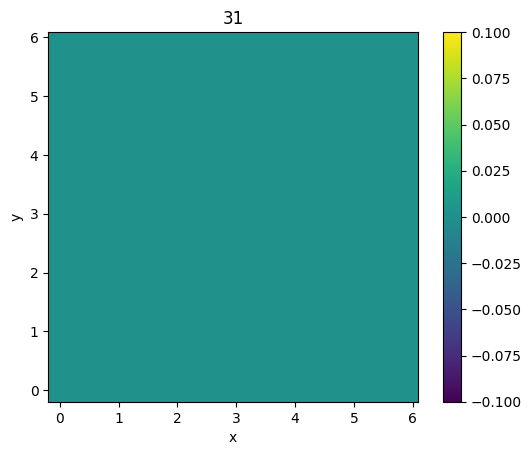

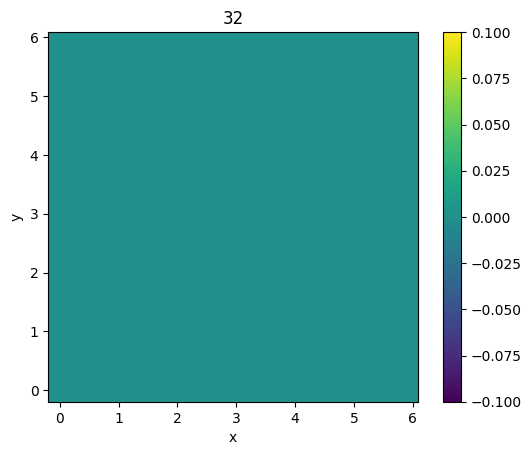

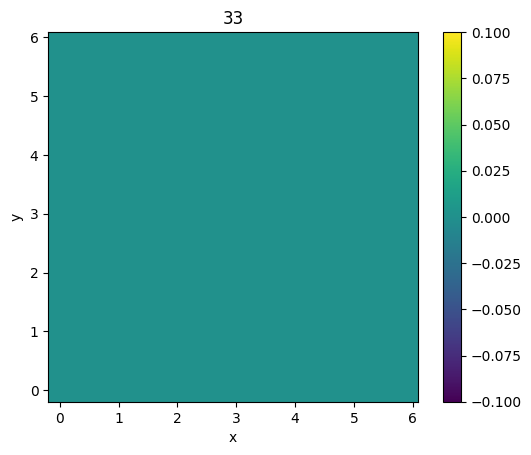

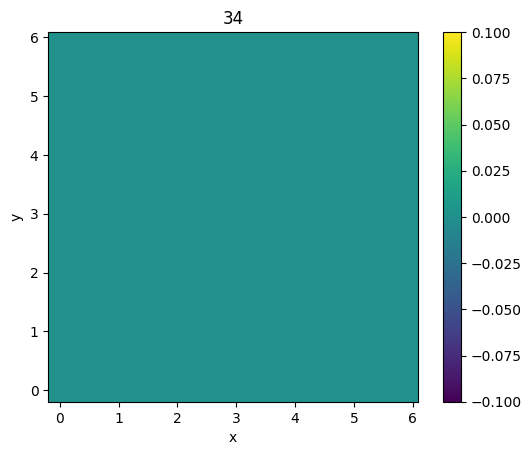

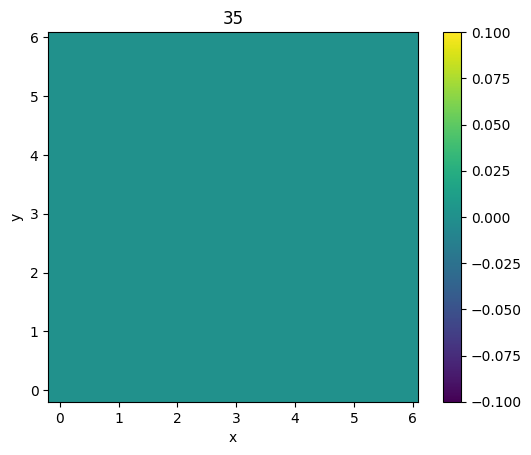

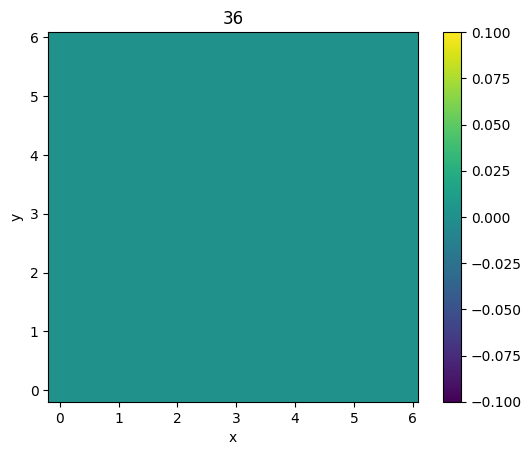

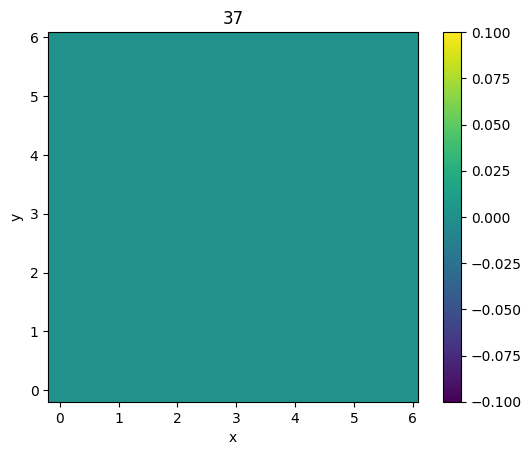

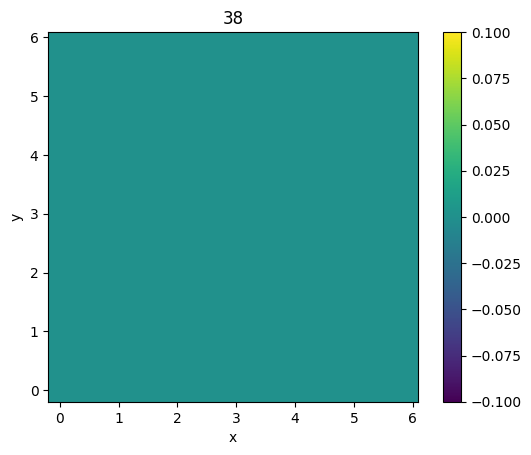

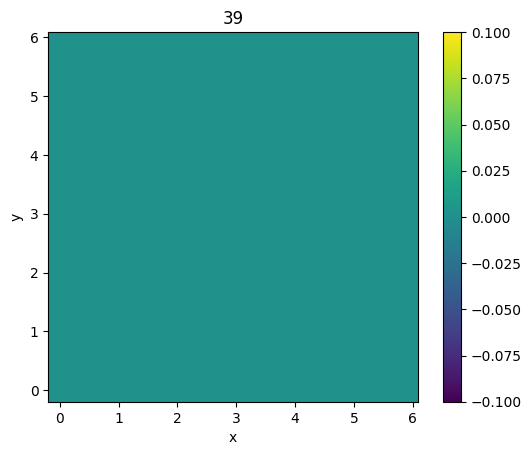

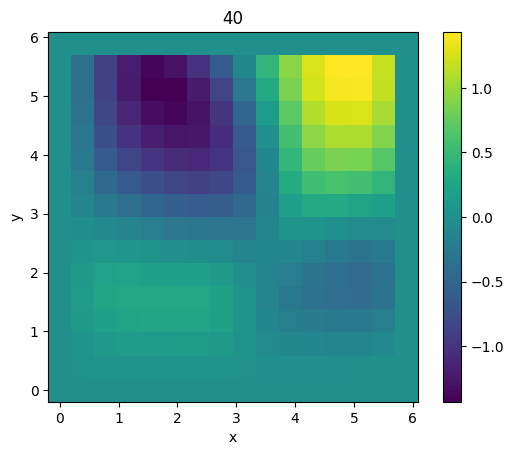

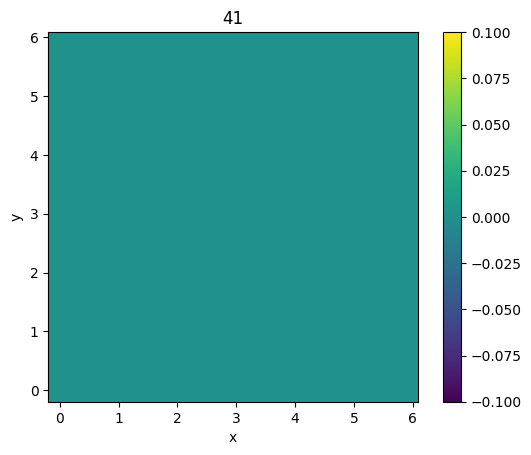

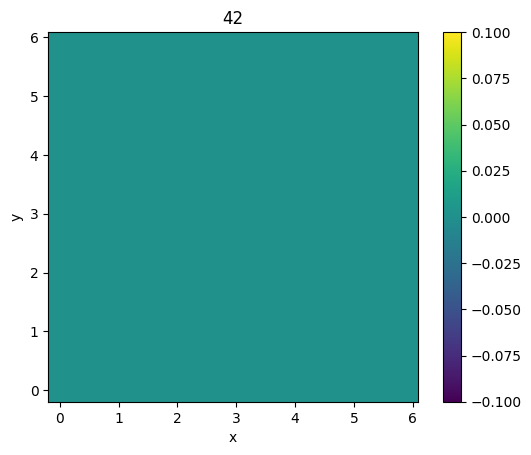

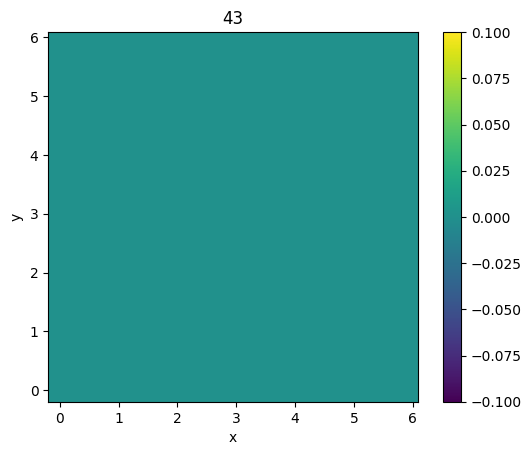

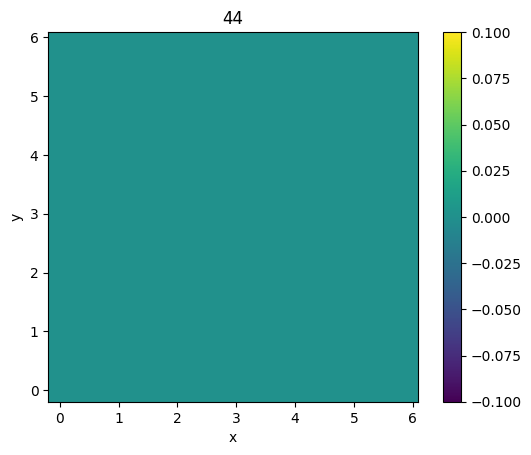

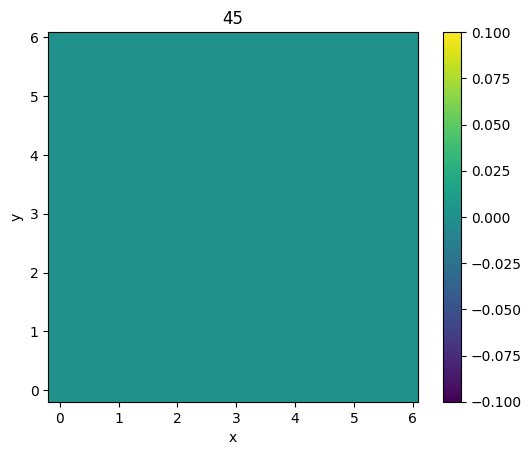

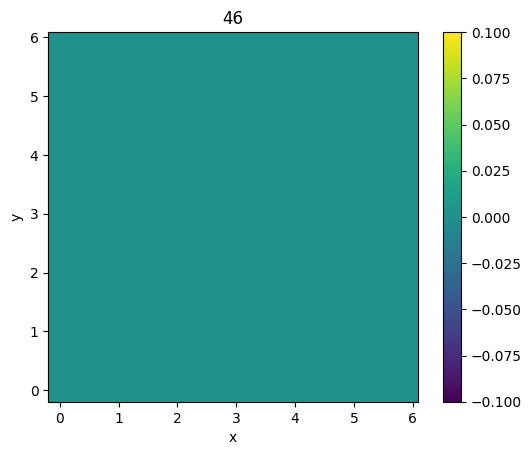

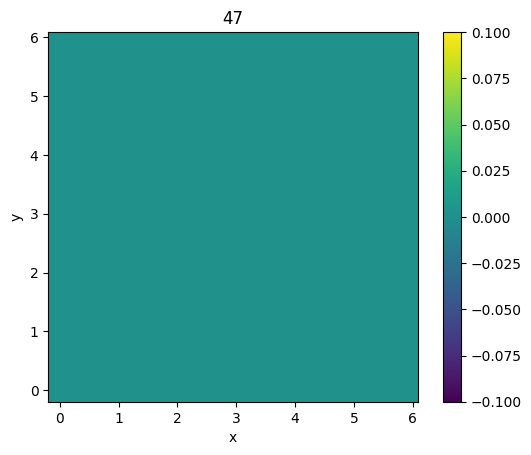

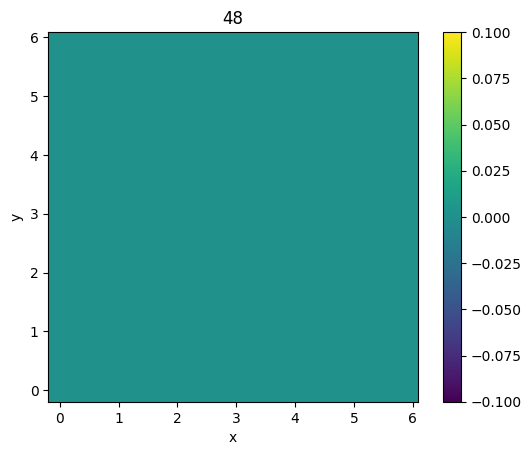

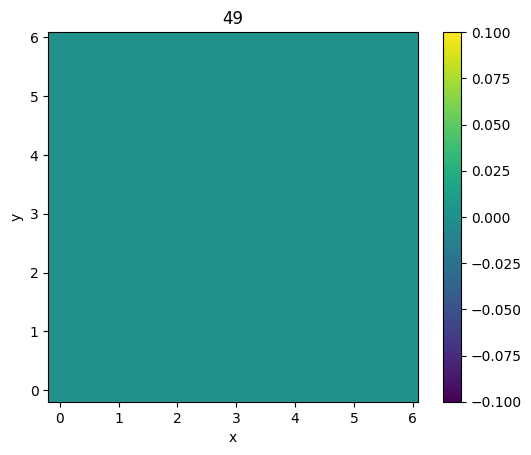

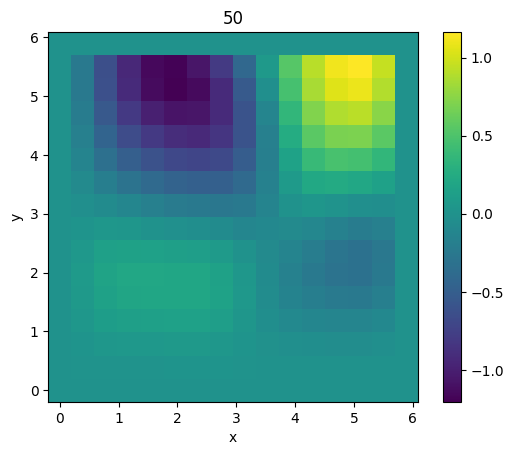

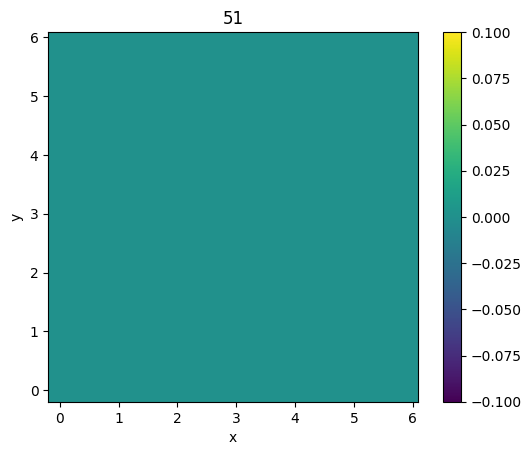

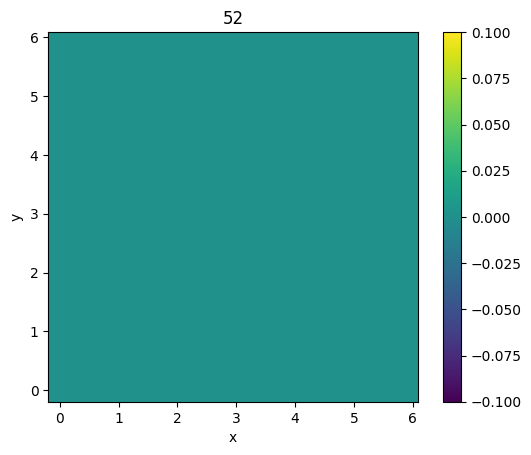

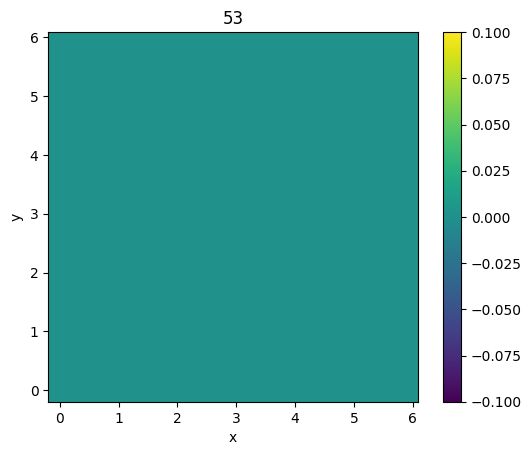

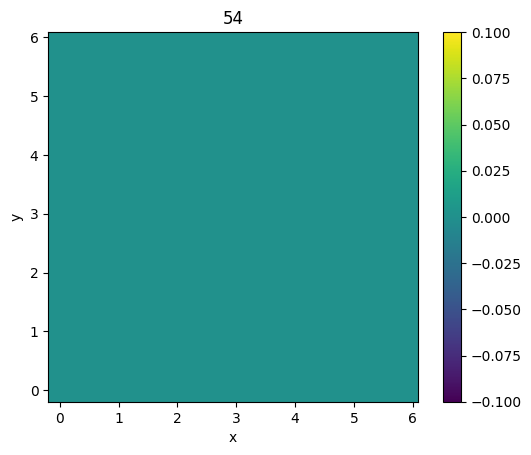

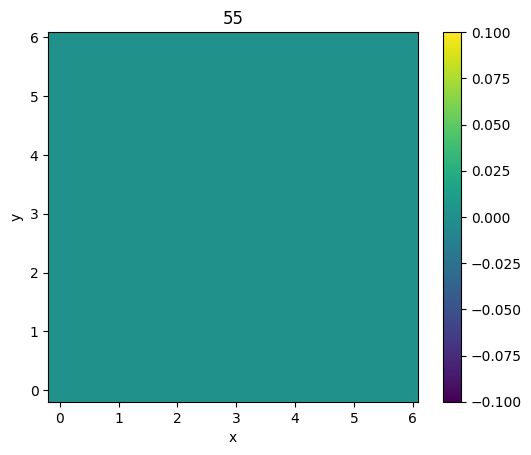

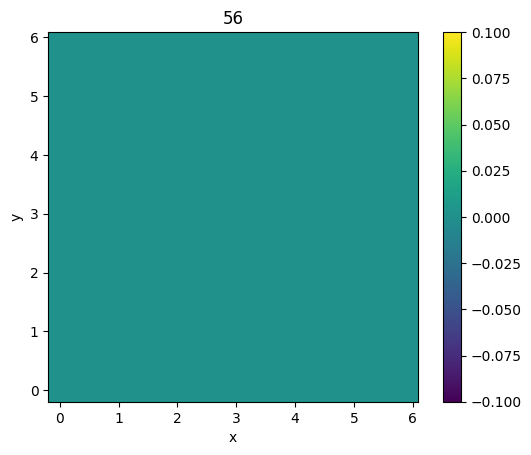

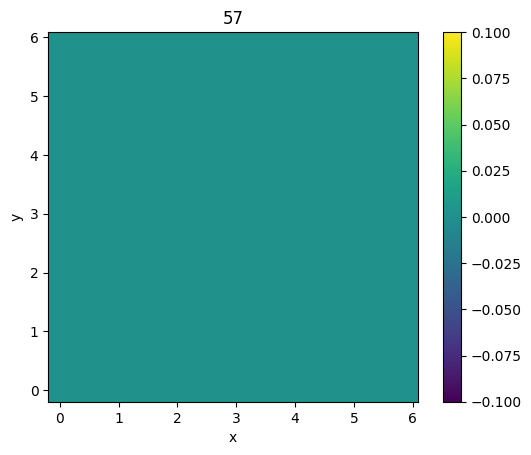

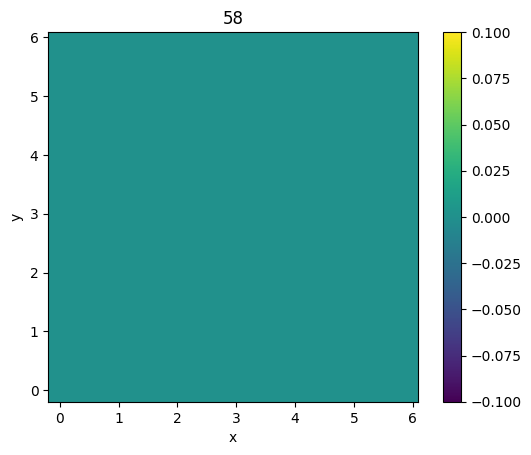

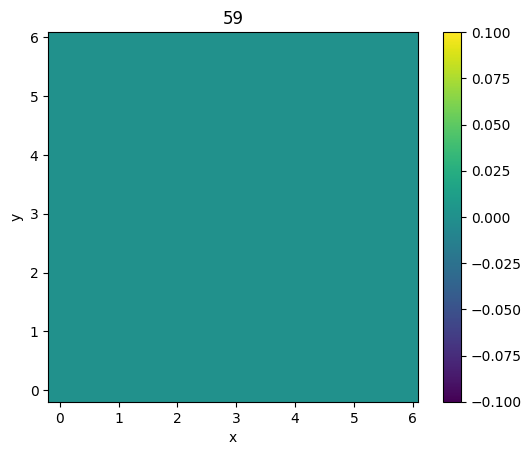

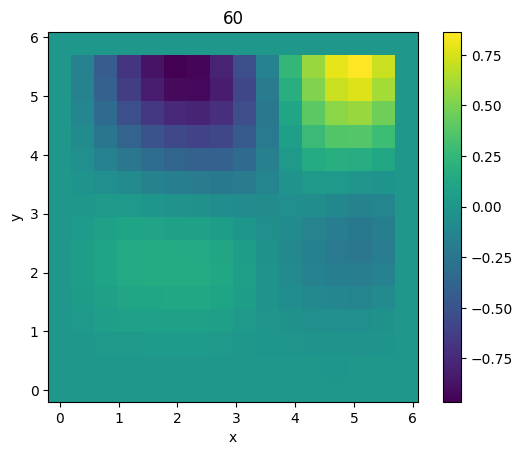

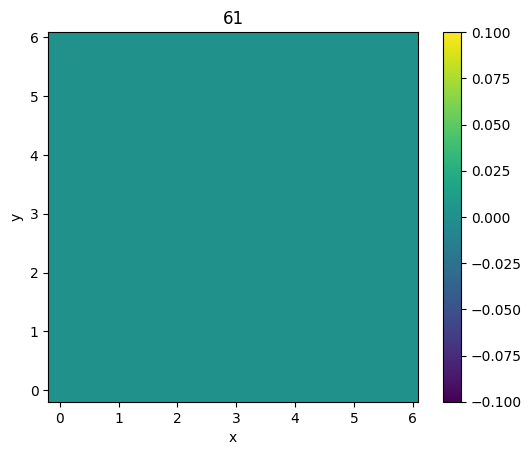

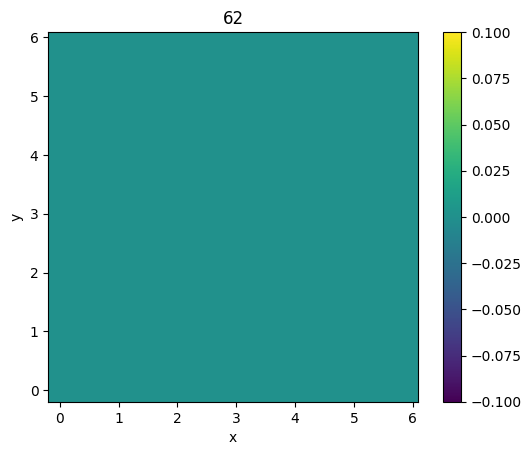

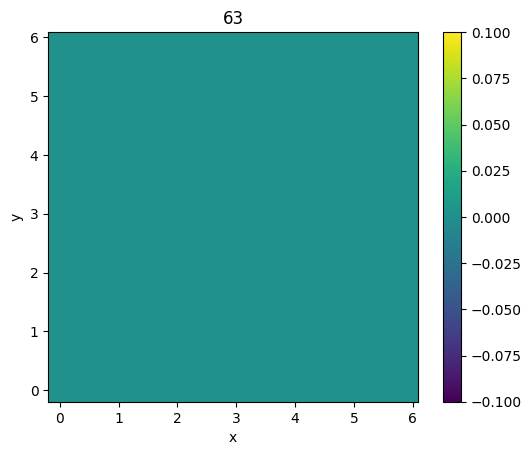

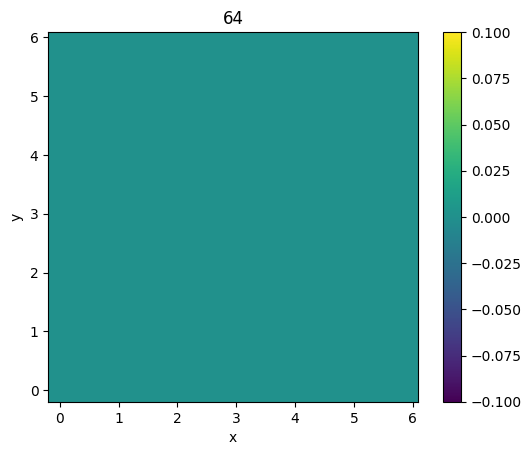

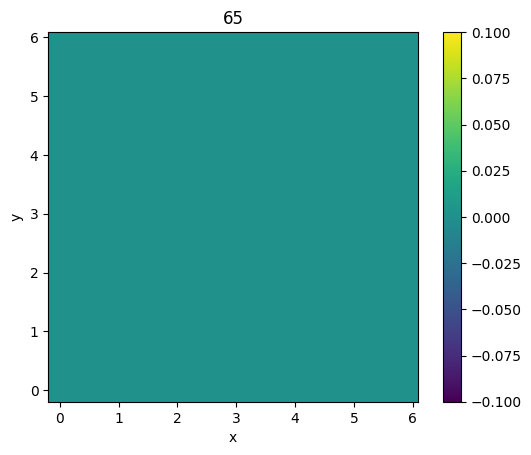

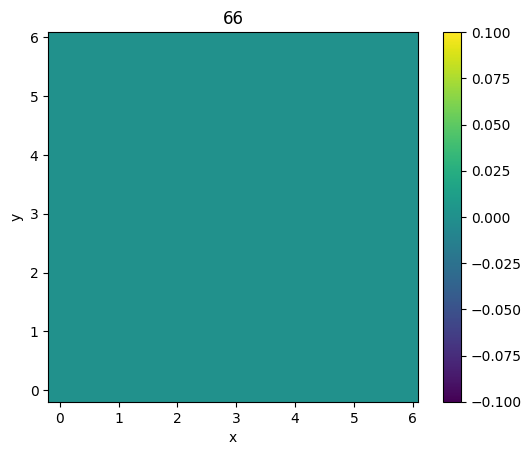

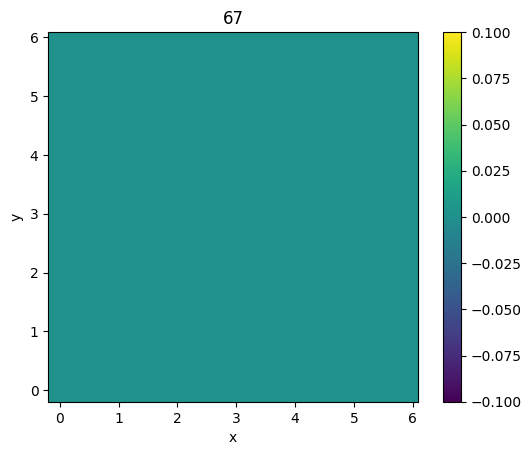

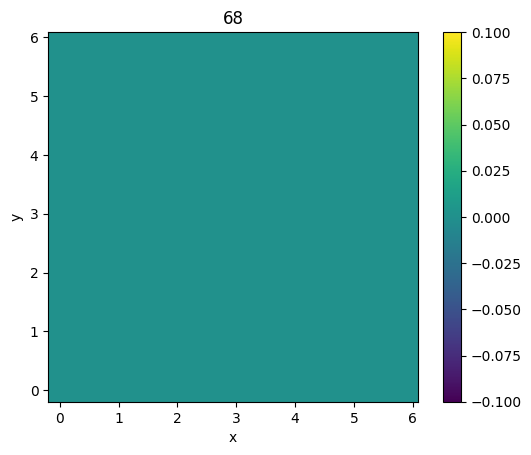

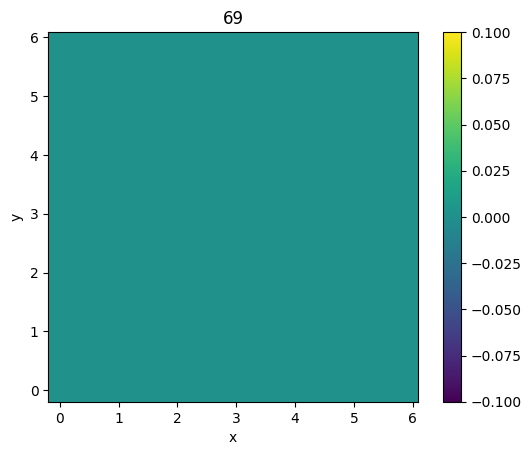

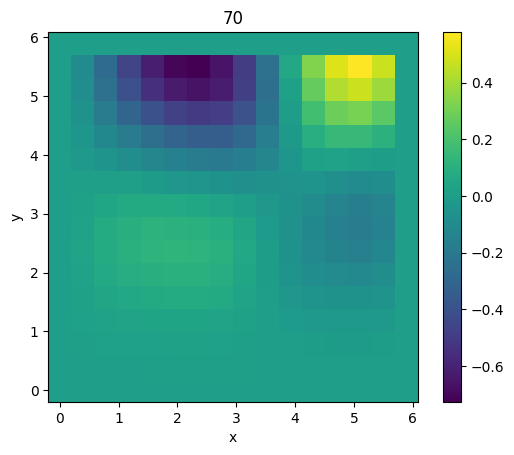

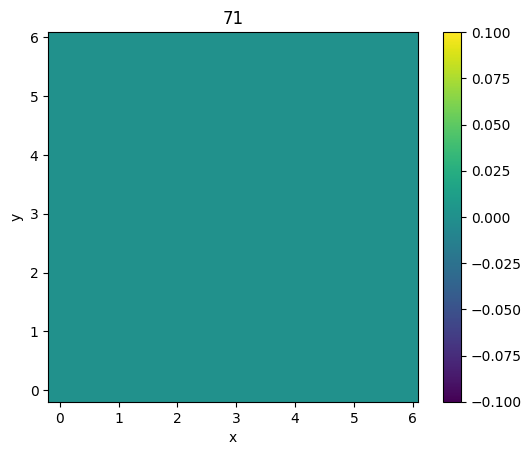

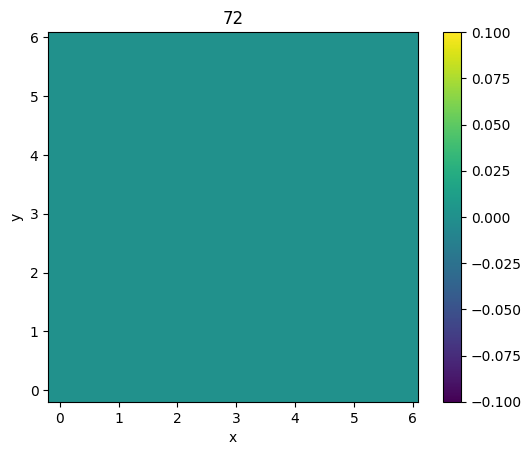

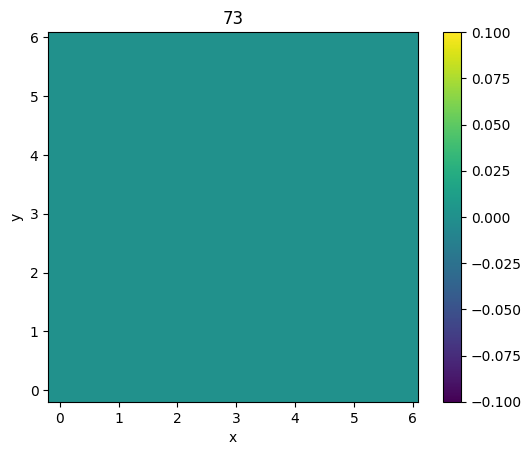

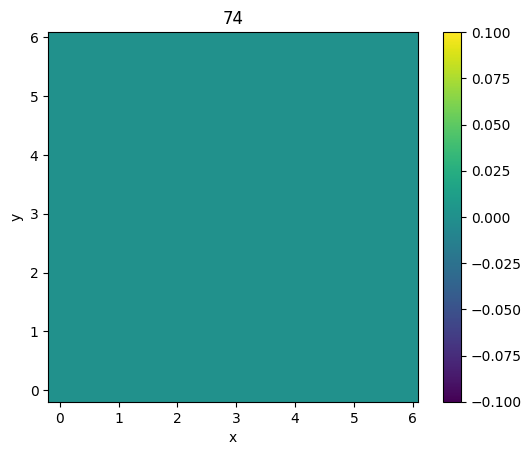

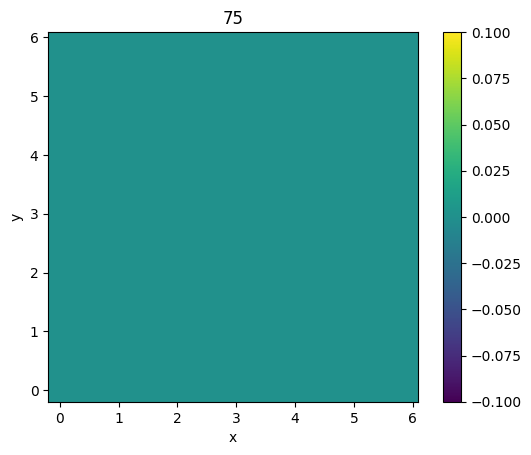

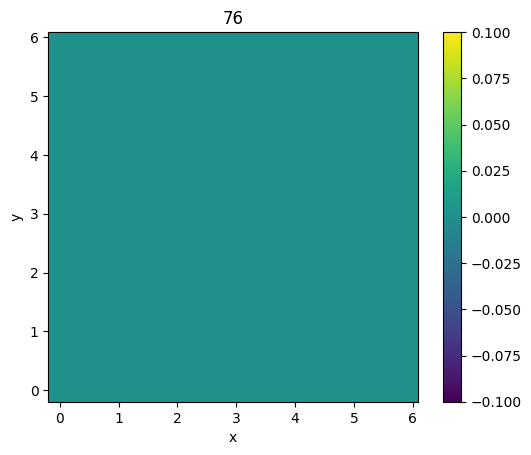

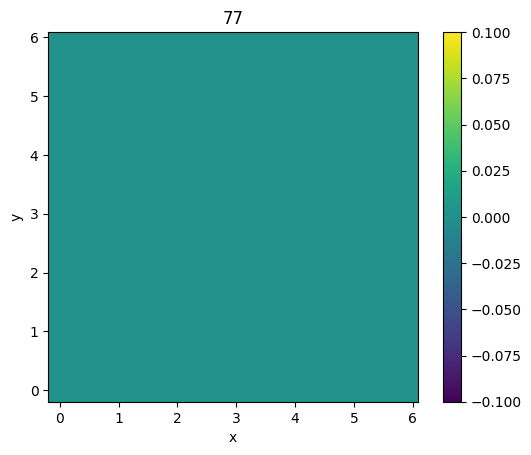

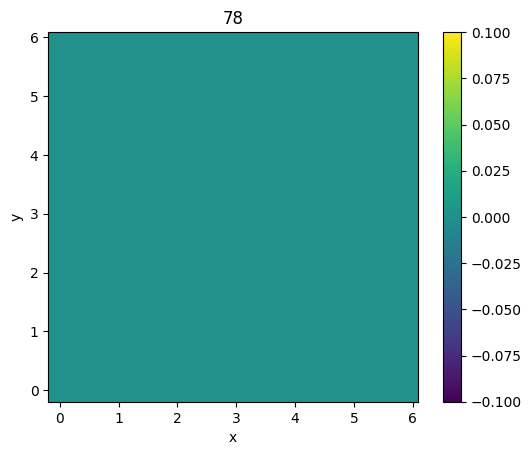

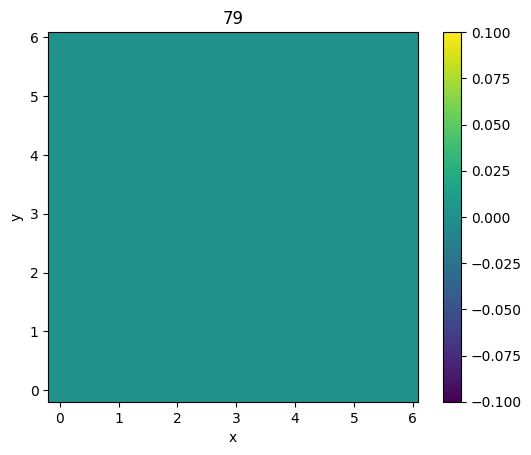

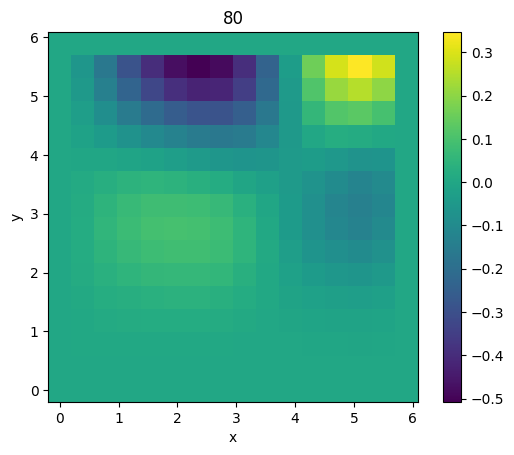

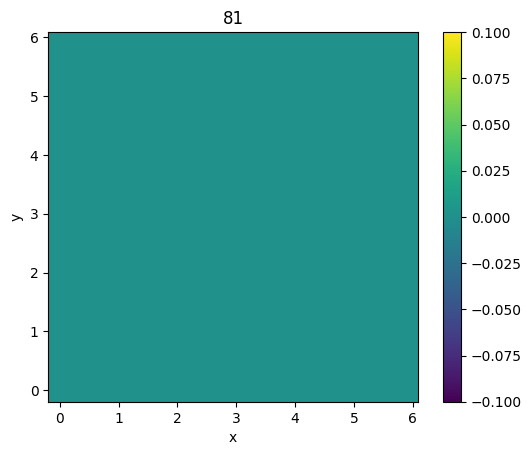

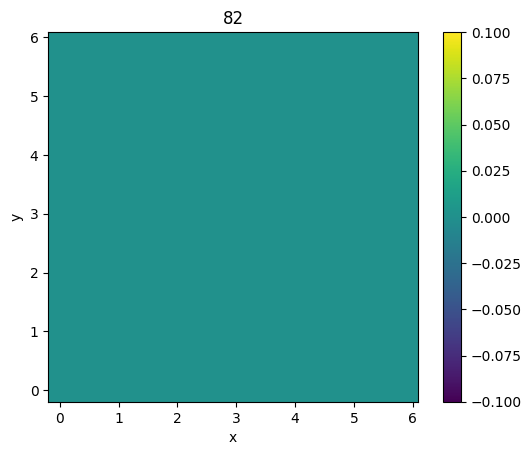

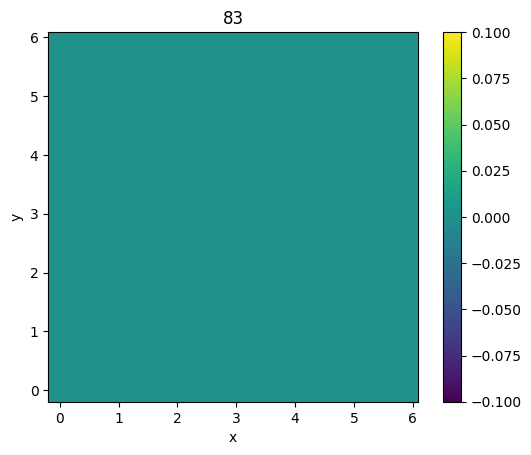

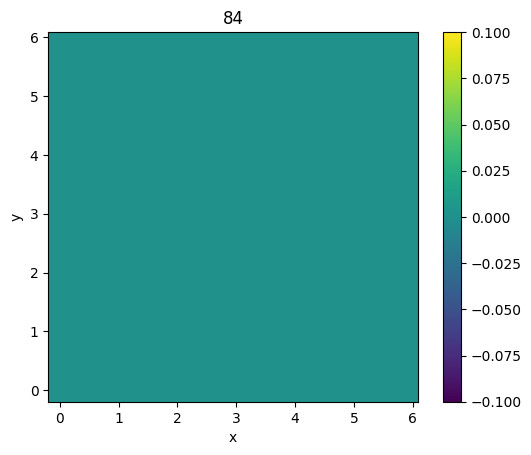

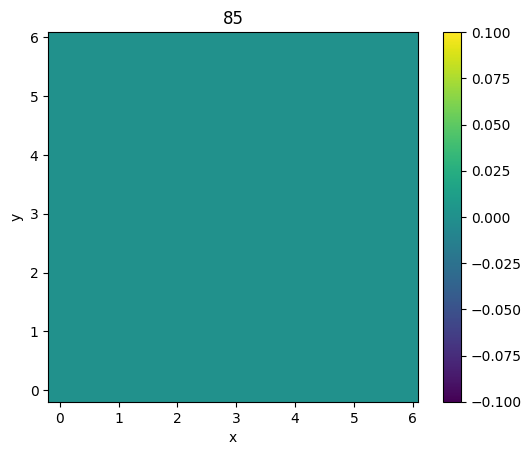

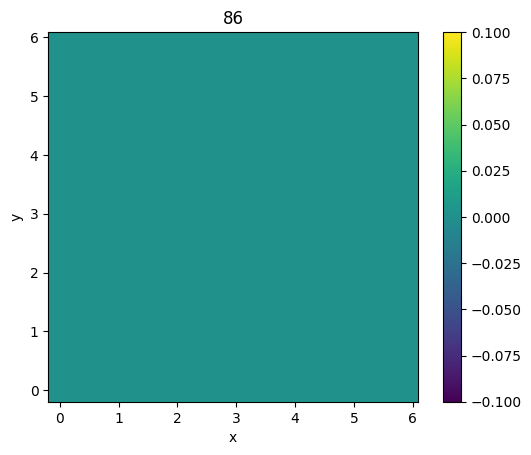

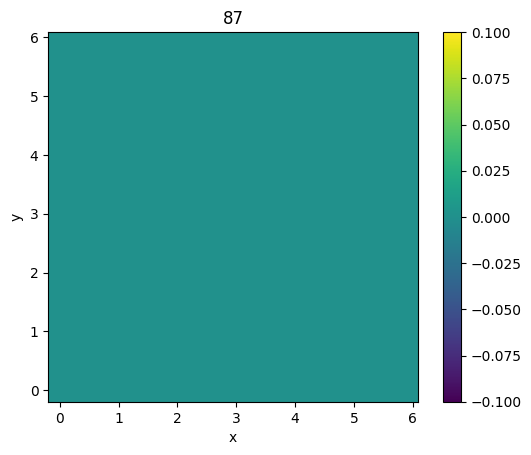

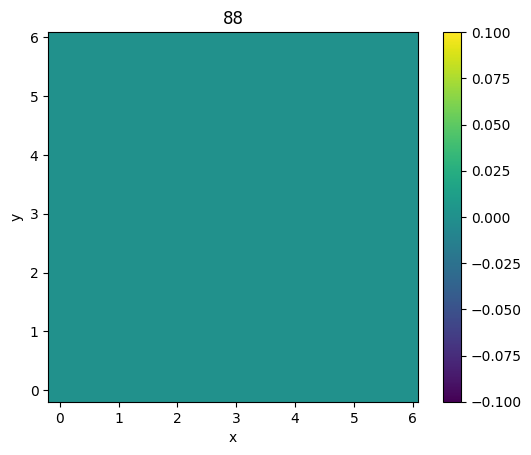

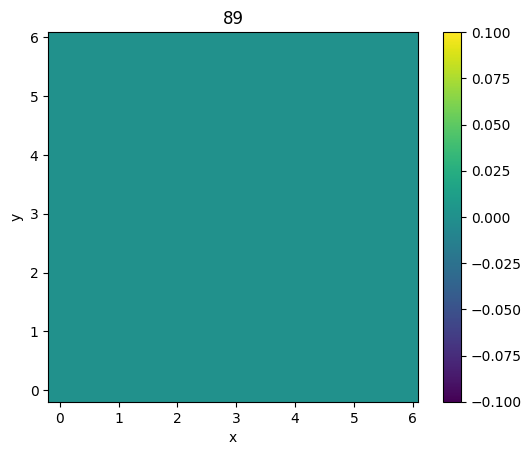

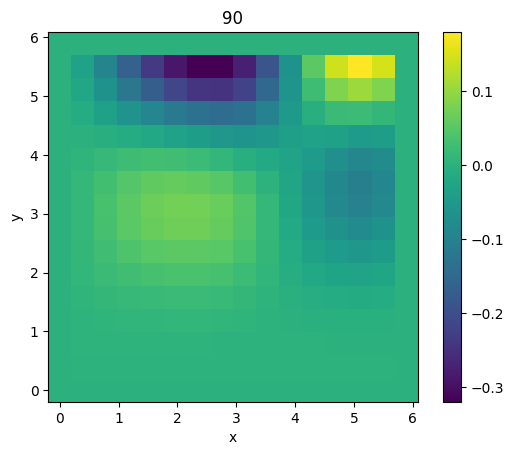

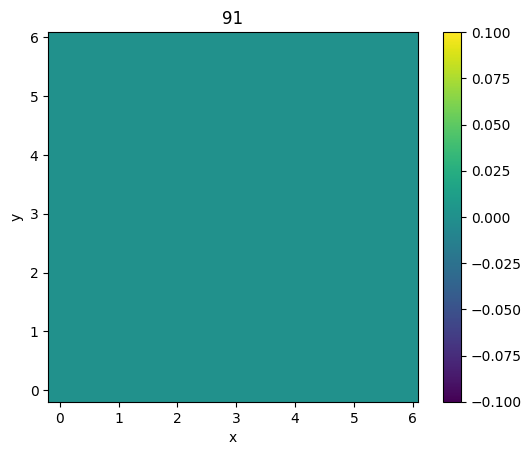

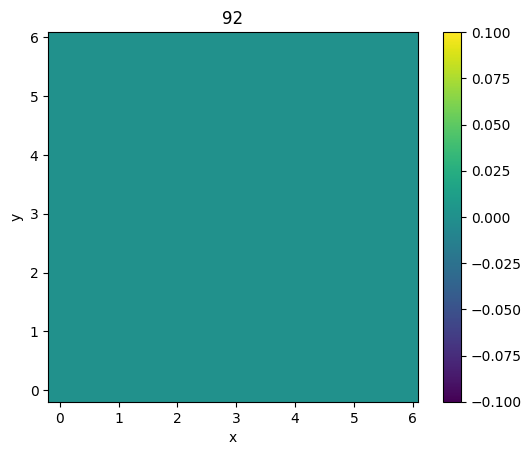

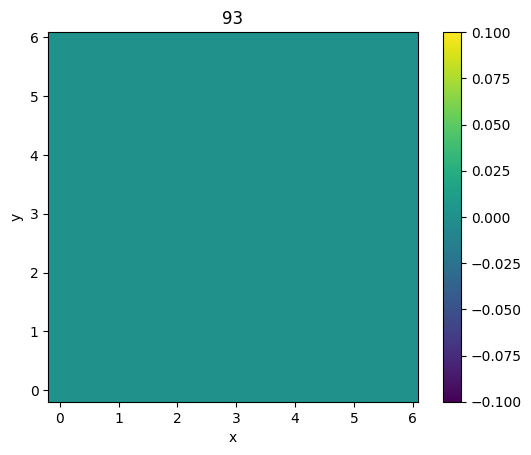

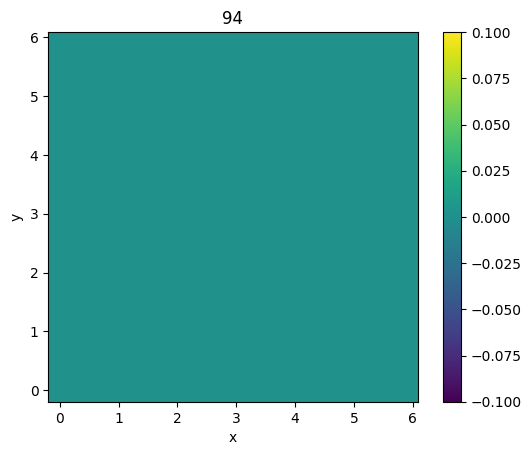

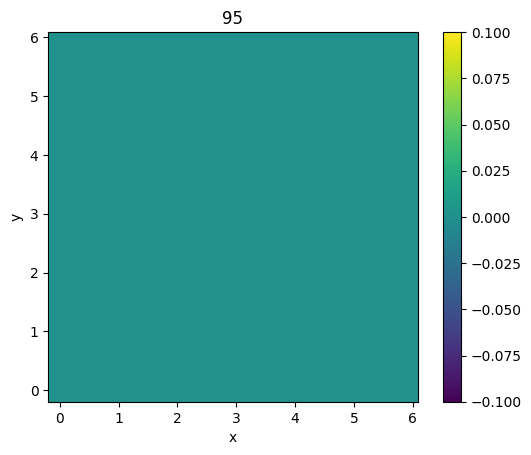

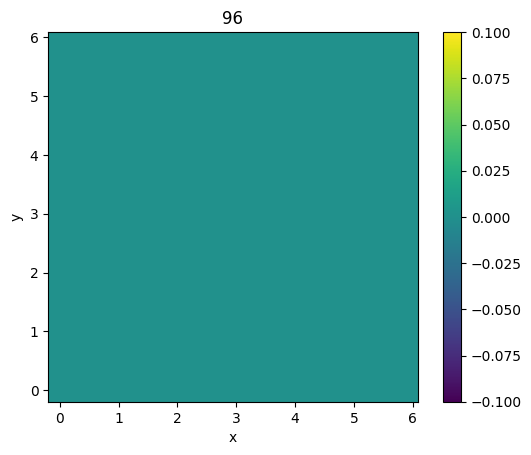

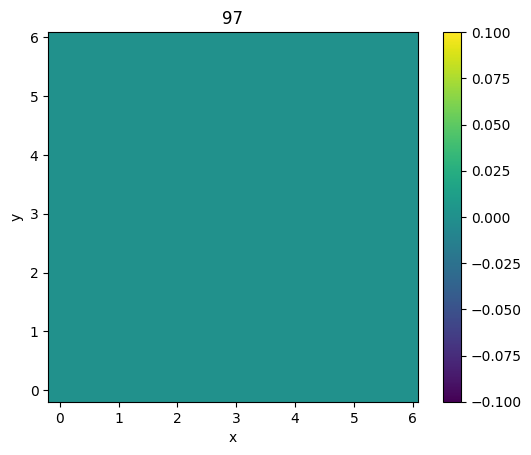

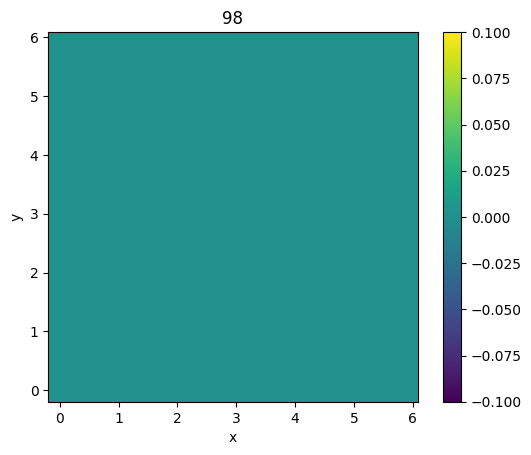

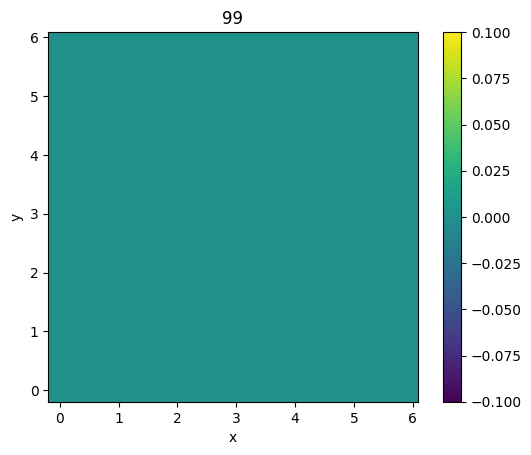

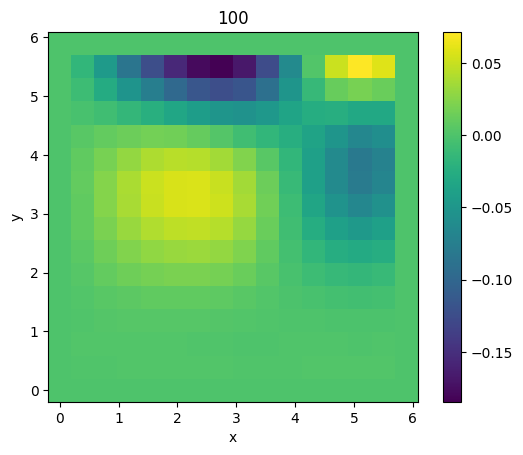

start_idxs=Array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100], dtype=int32), err=0


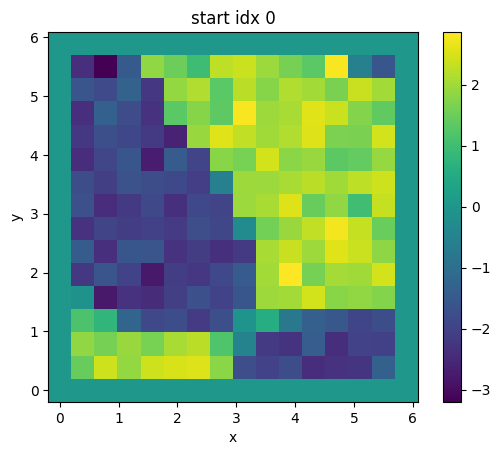

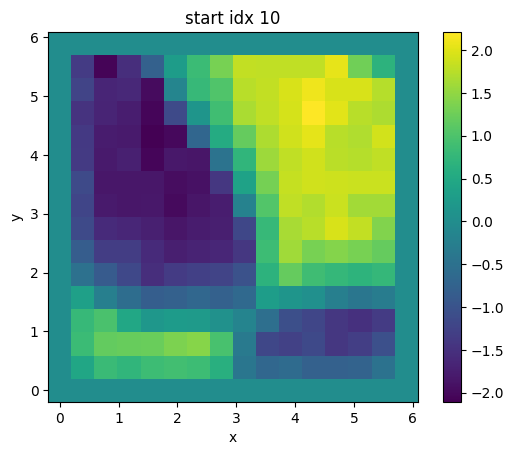

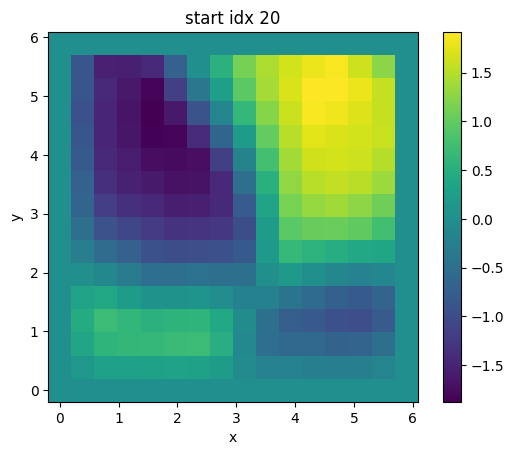

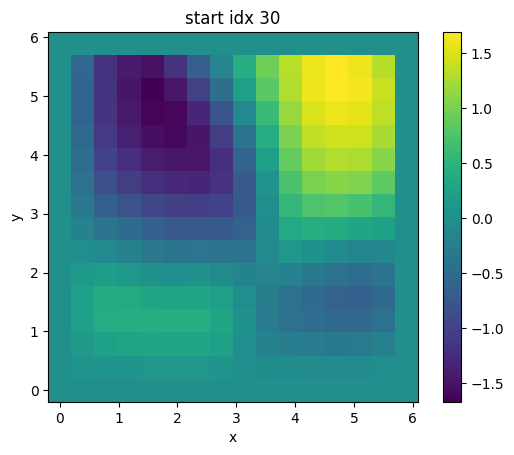

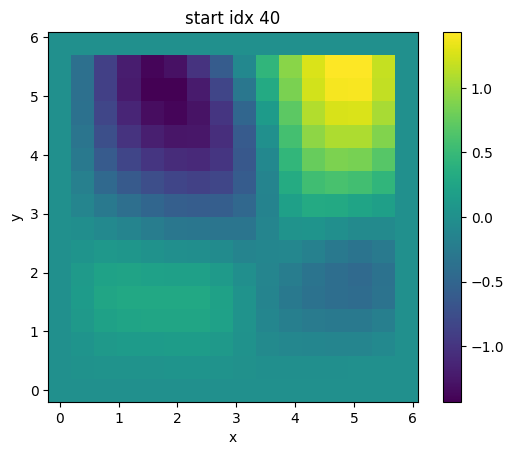

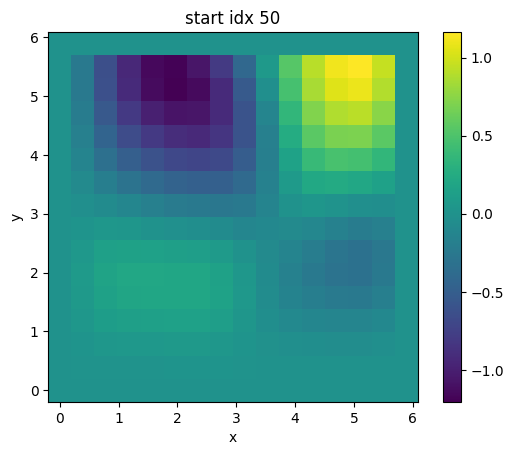

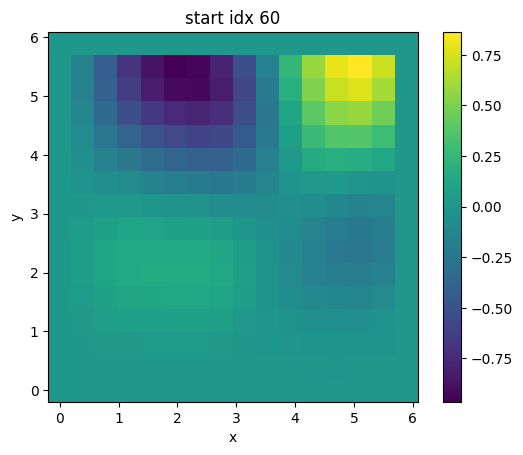

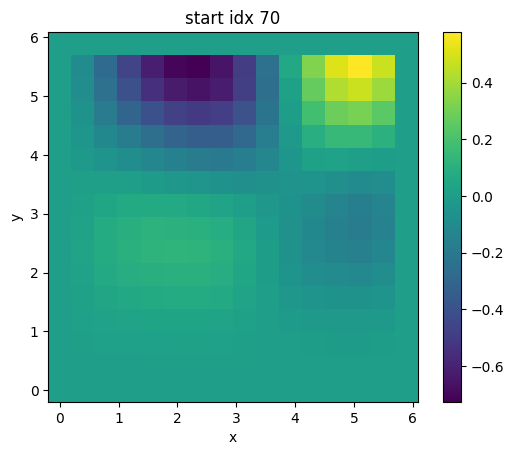

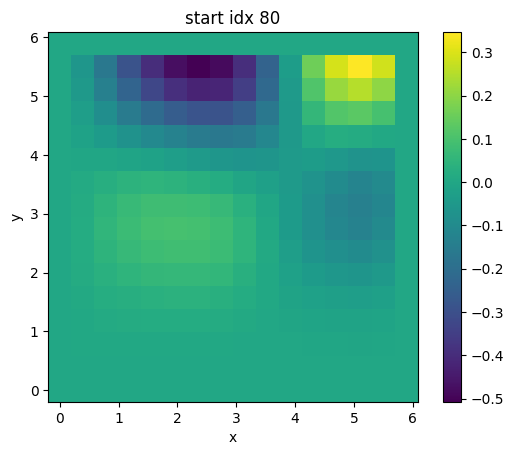

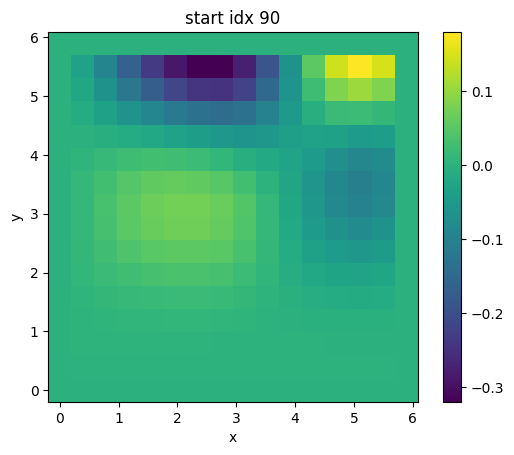

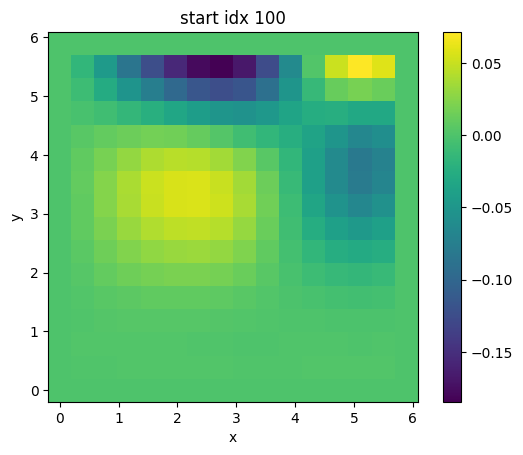

(11, 11, 16, 16)
at time 1


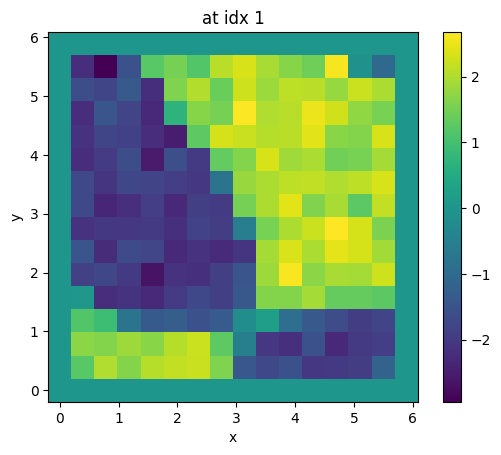

at time 2


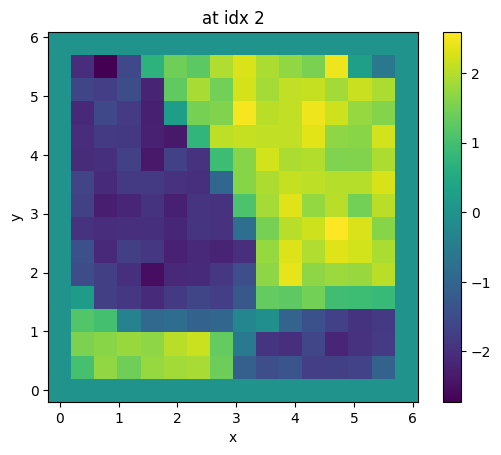

at time 3


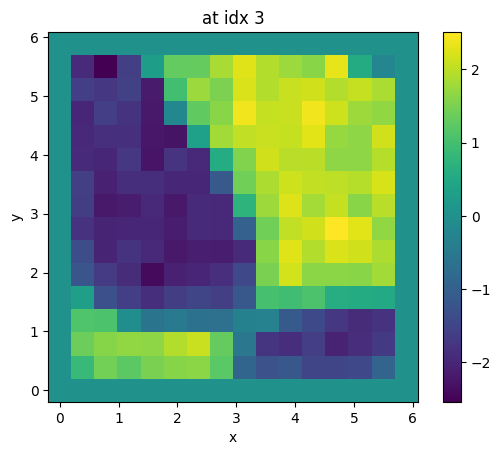

at time 4


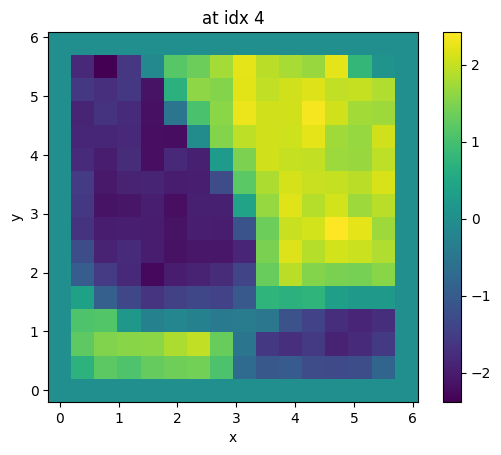

at time 5


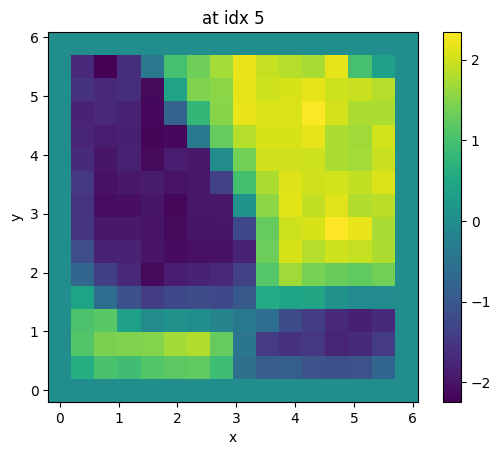

at time 6


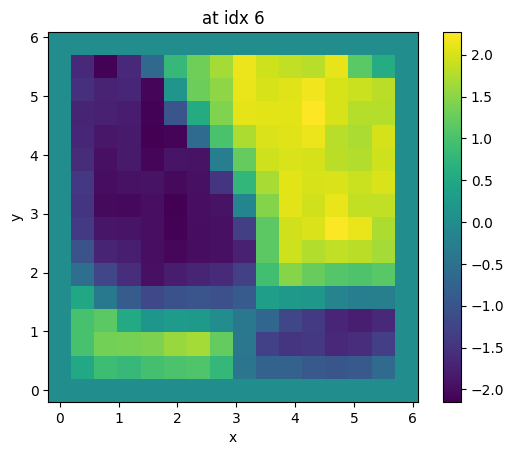

at time 7


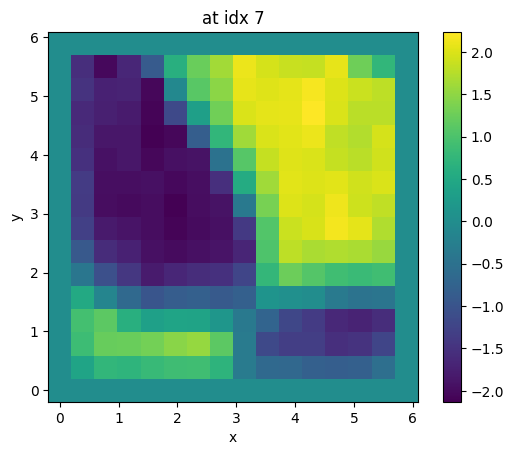

at time 8


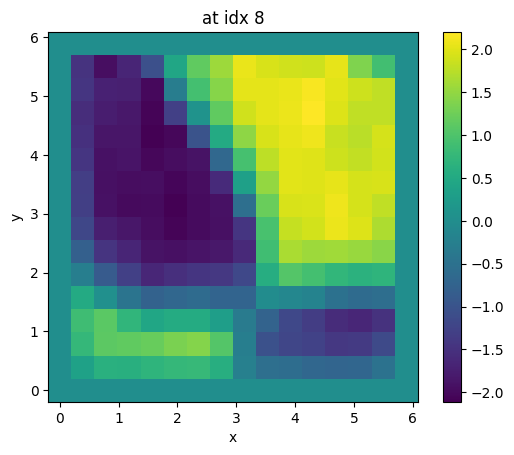

at time 9


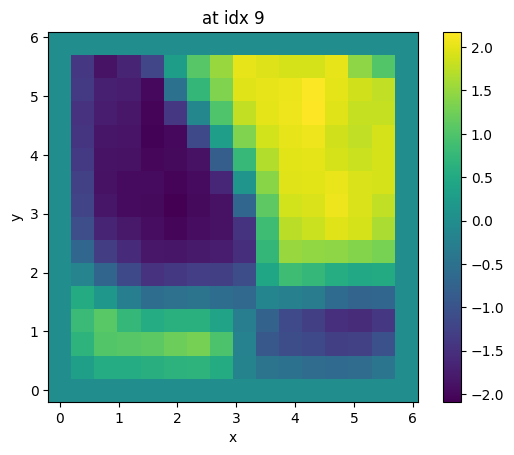

at time 10


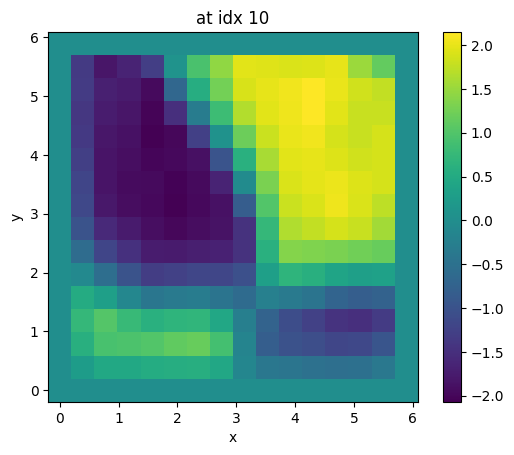

at time 11


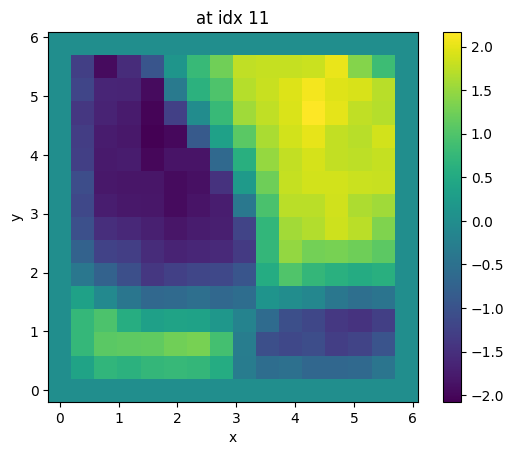

at time 12


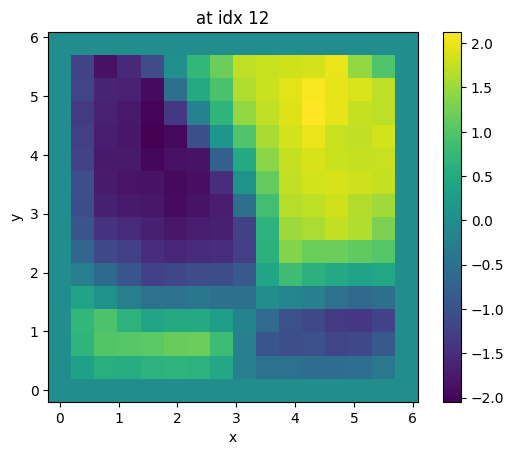

at time 13


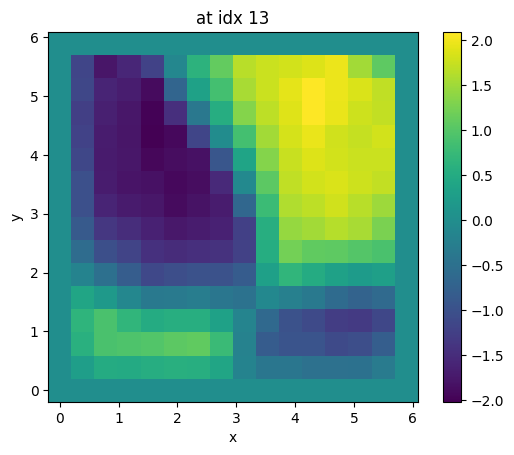

at time 14


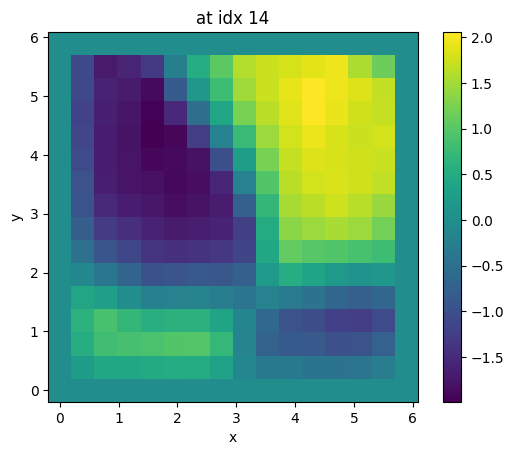

at time 15


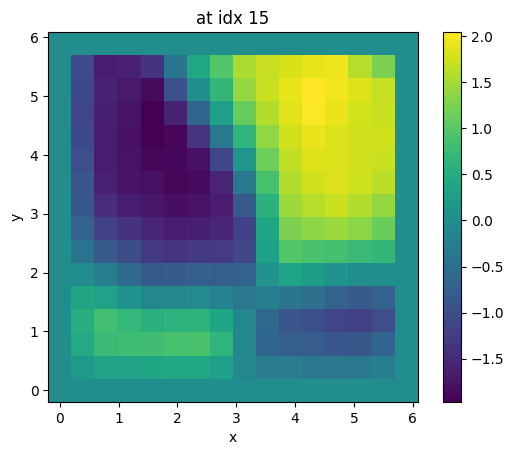

at time 16


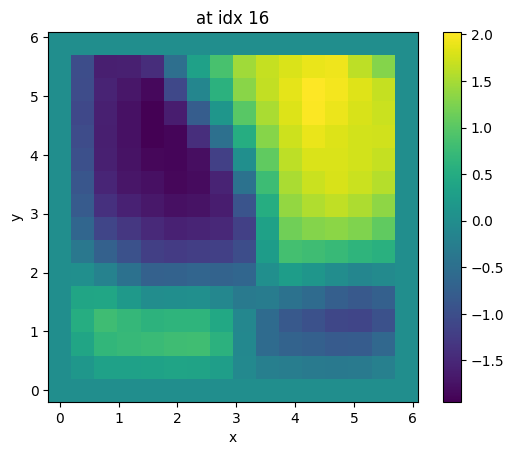

at time 17


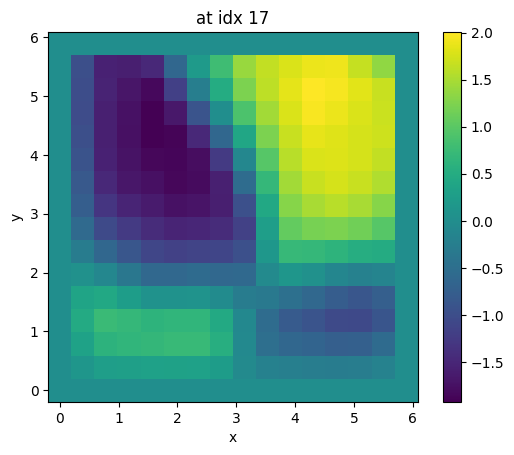

at time 18


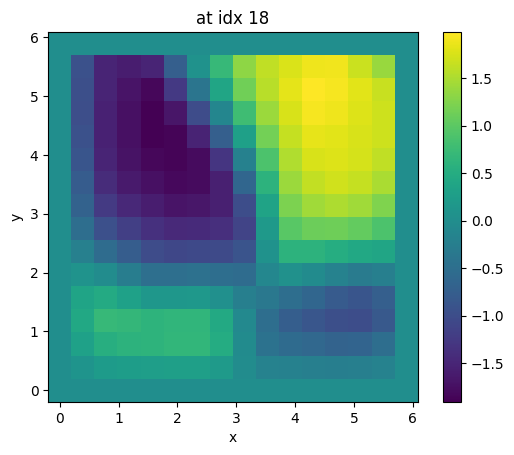

at time 19


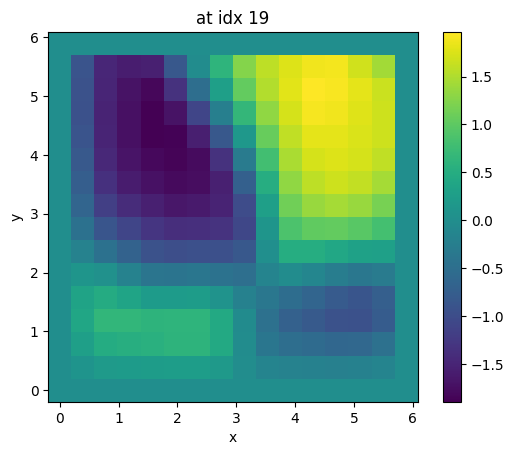

at time 20


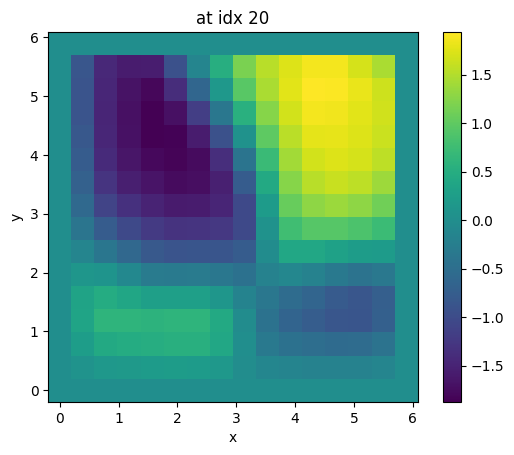

at time 21


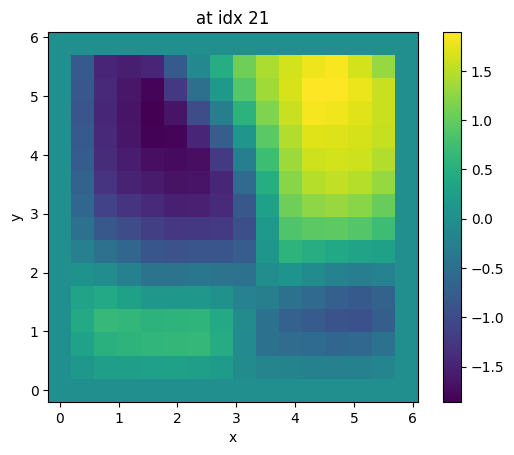

at time 22


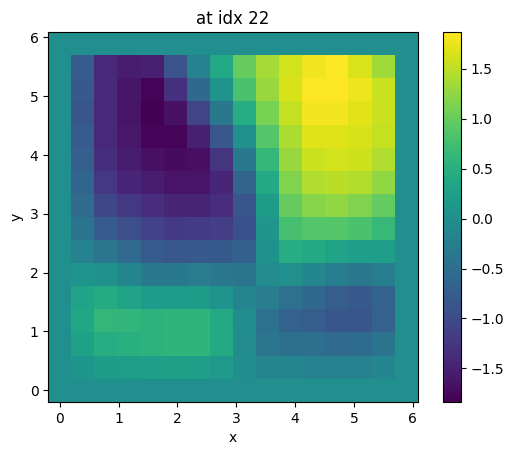

at time 23


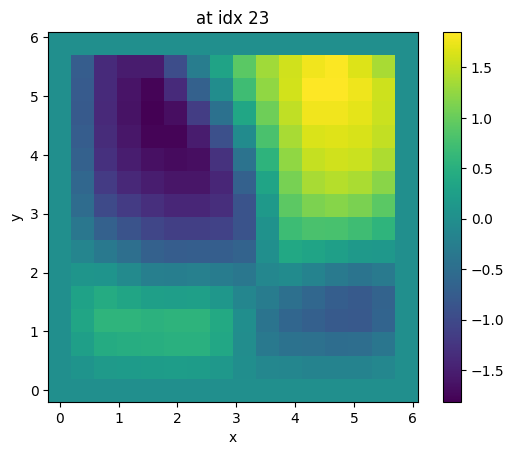

at time 24


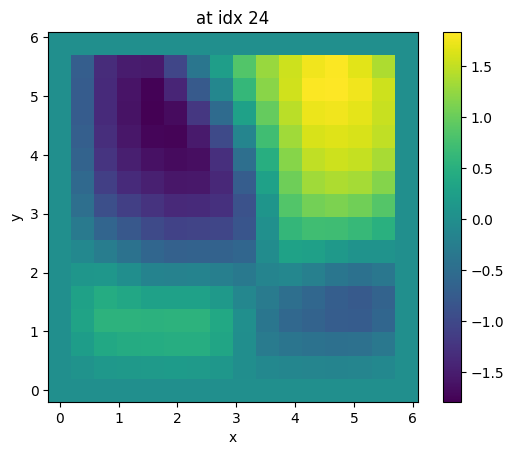

at time 25


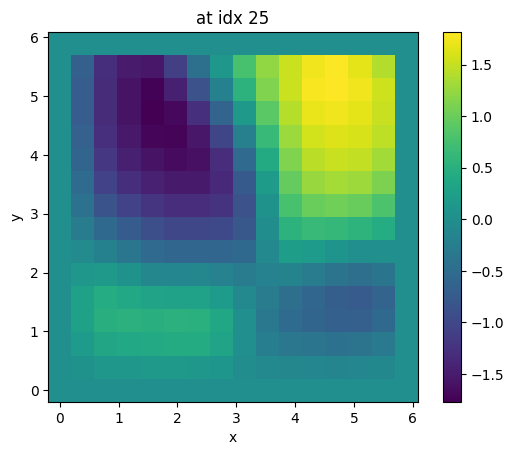

at time 26


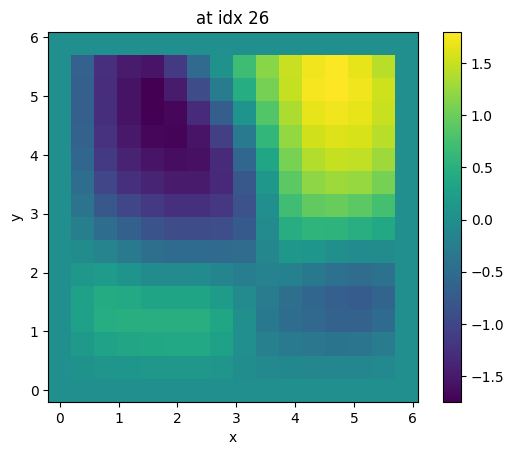

at time 27


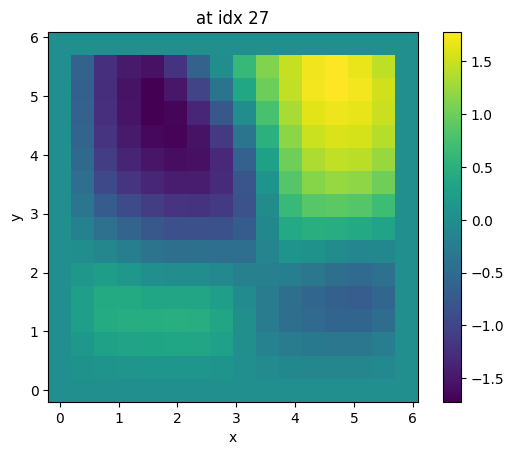

at time 28


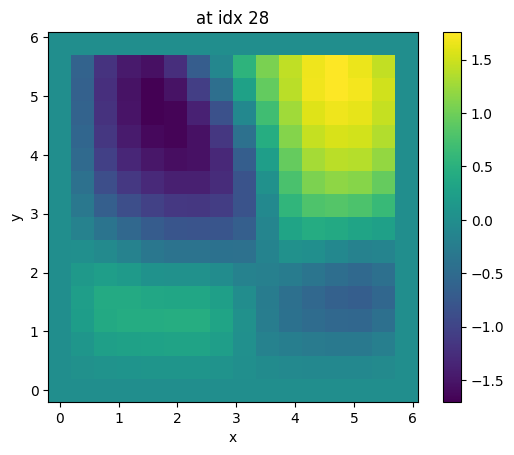

at time 29


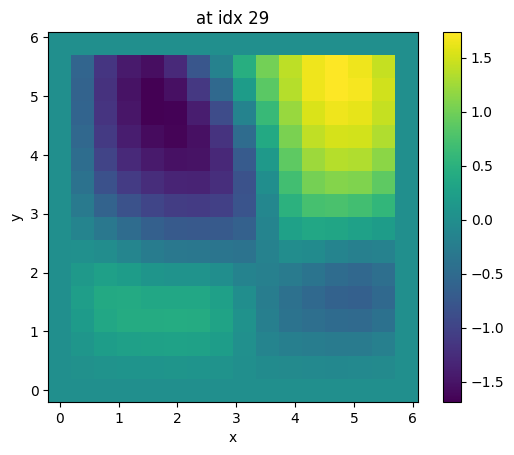

at time 30


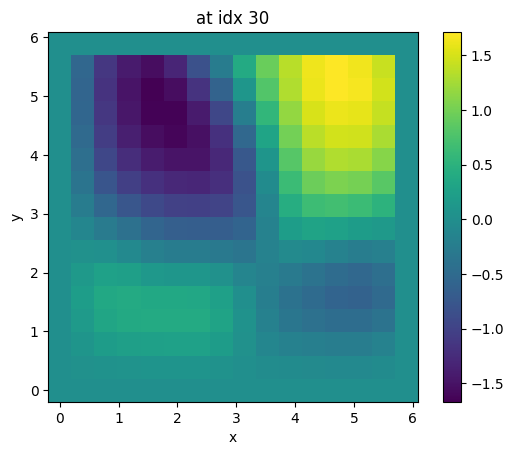

at time 31


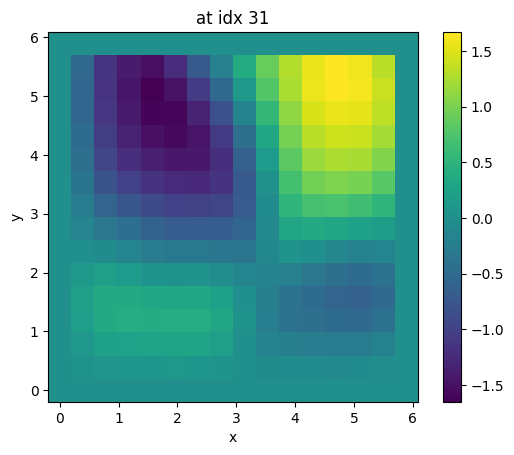

at time 32


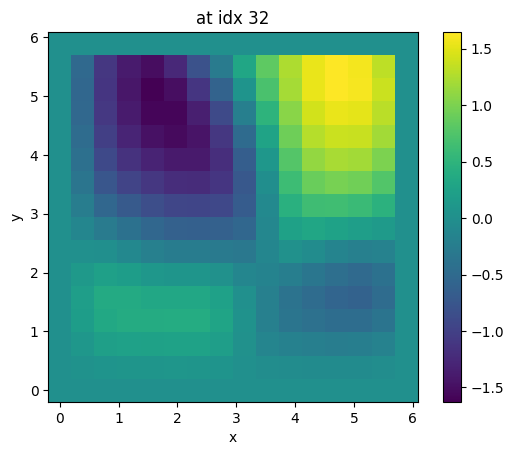

at time 33


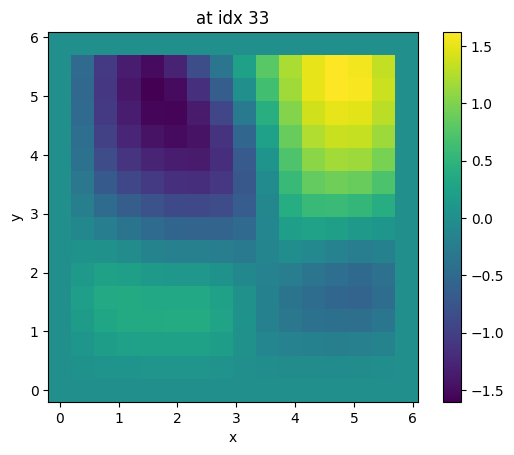

at time 34


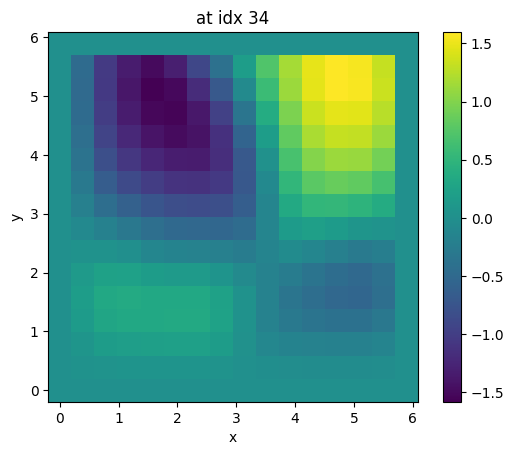

at time 35


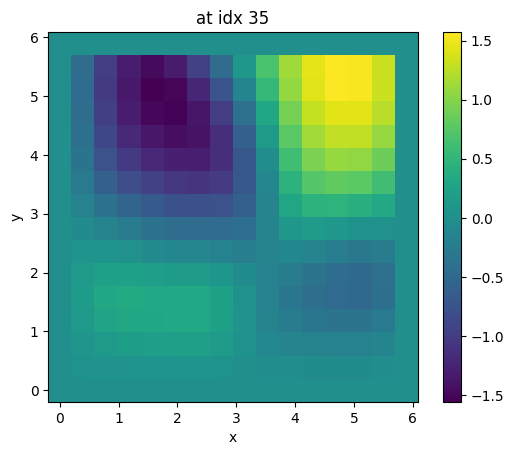

at time 36


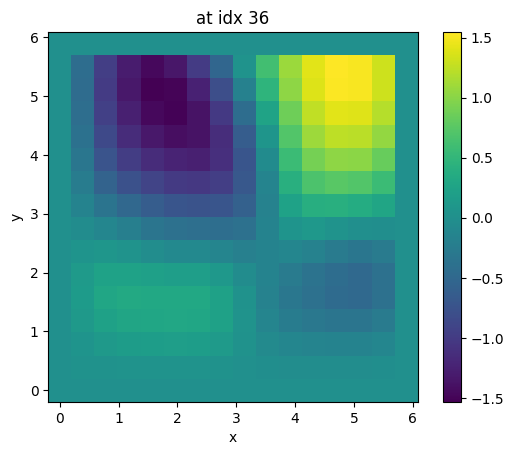

at time 37


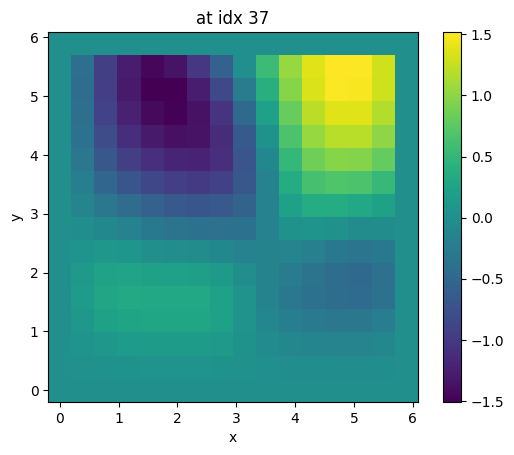

at time 38


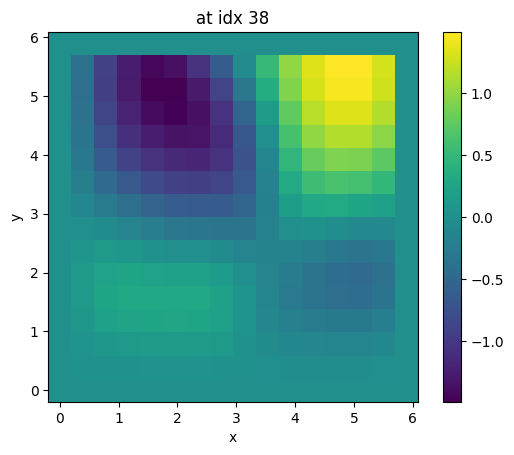

at time 39


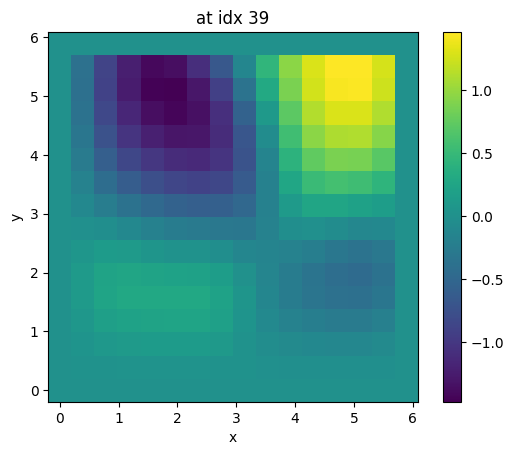

at time 40


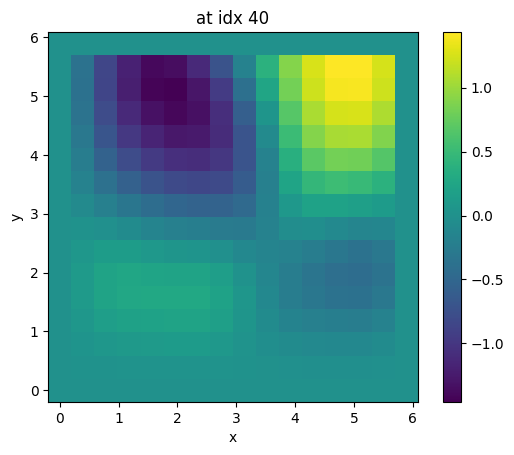

at time 41


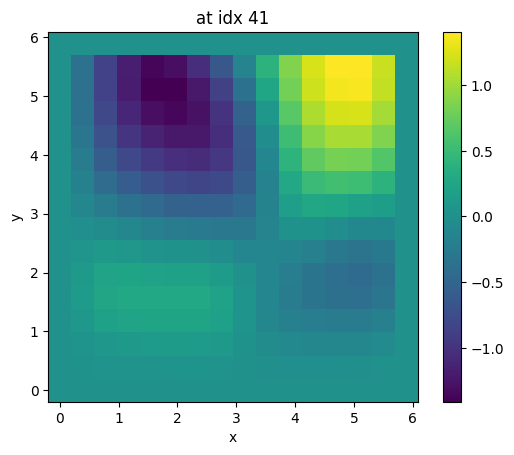

at time 42


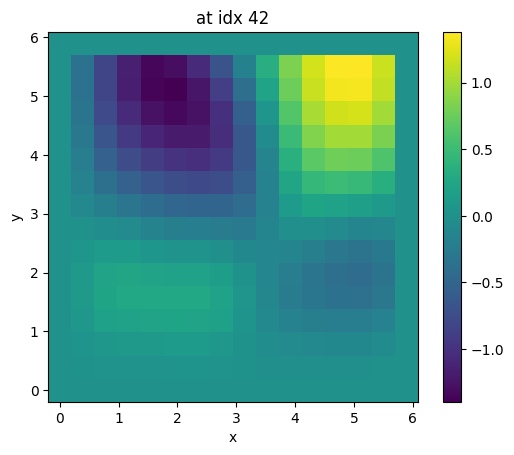

at time 43


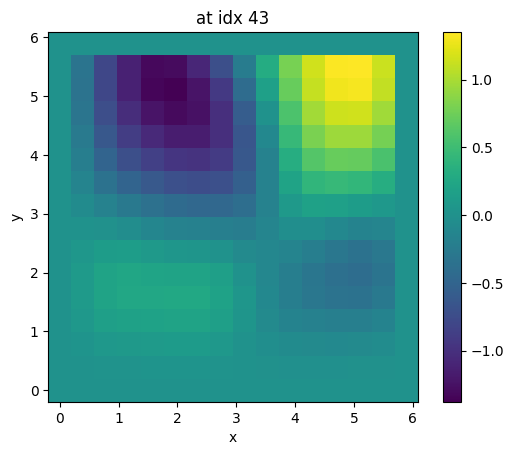

at time 44


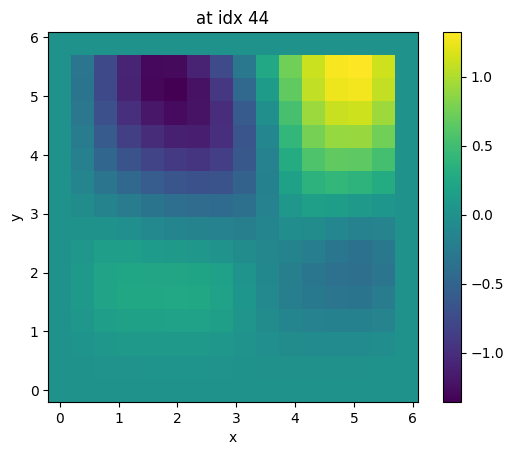

at time 45


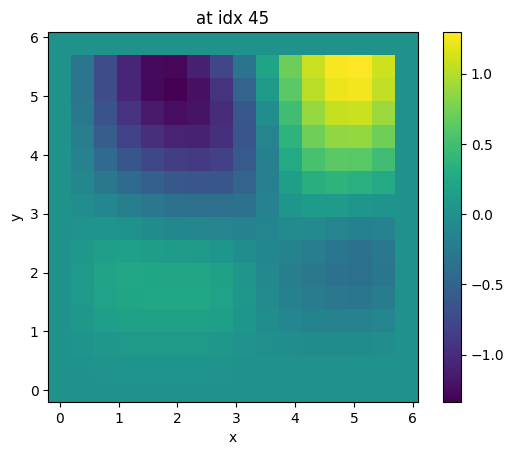

at time 46


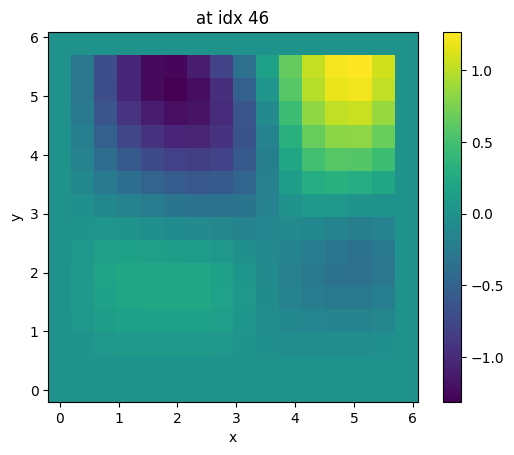

at time 47


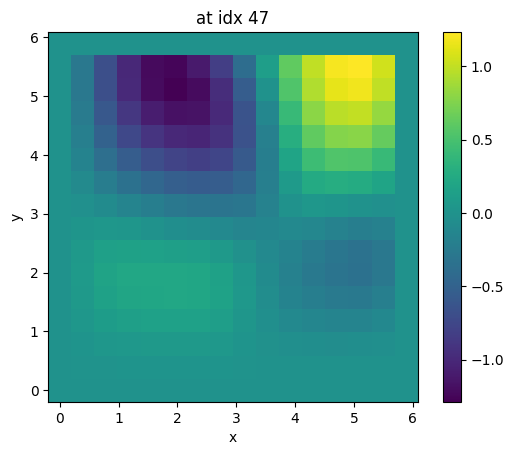

at time 48


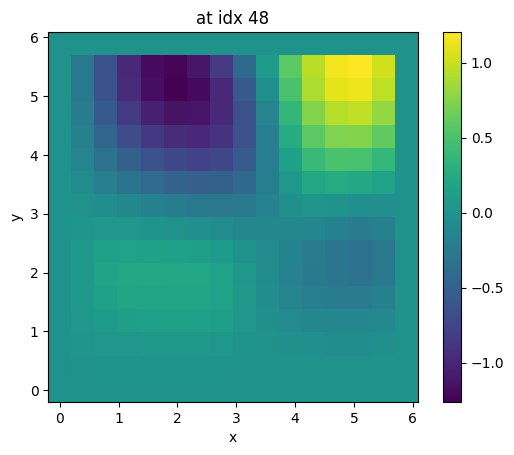

at time 49


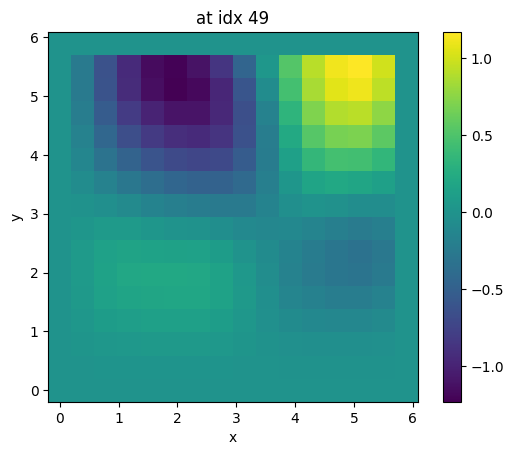

at time 50


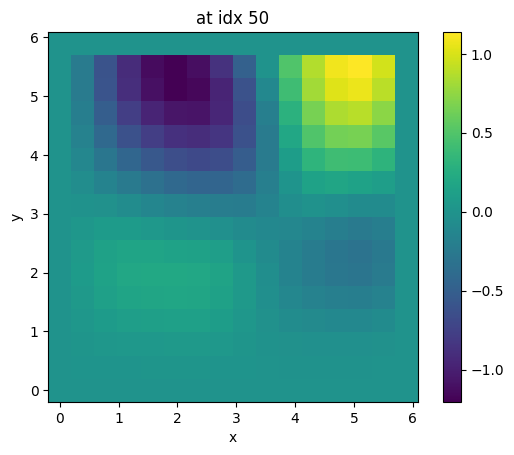

at time 51


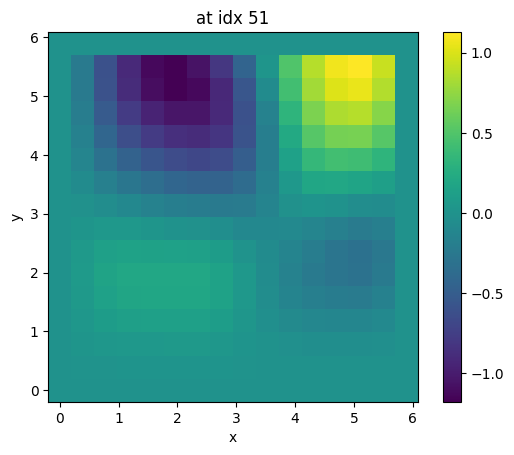

at time 52


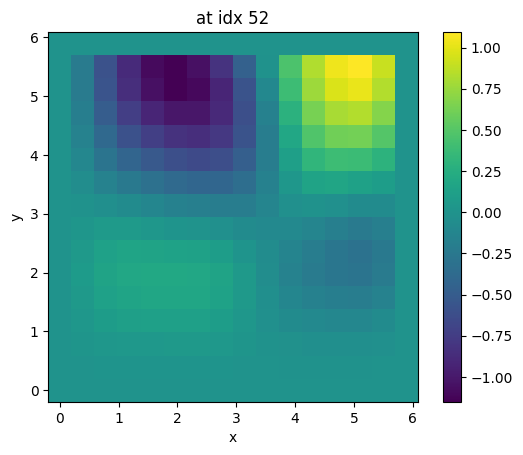

at time 53


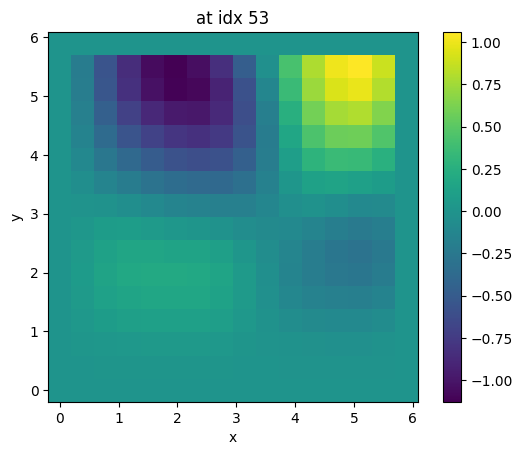

at time 54


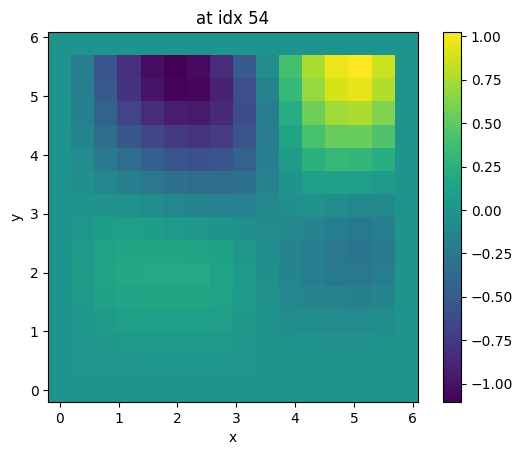

In [ ]:
#@title Parareal
import numpy as np
import time

N = 16
def predict(x, model, bc = "dirichlet"):
        x = jnp.reshape(x, newshape = (1, N, N))
        x = np.asarray(x)
        x = torch.tensor(x, dtype = torch.float32)
        data = {'x': x, 'y': x}
        # data = data_processor.preprocess(data, batched=False)
        # Input x
        x = data['x']
        # print(f"{x.shape=}")
        # Ground-truth
        # y = data['y']
        # Model prediction
        out = model(x.unsqueeze(0))
        out = jnp.array(out.squeeze().detach().numpy())
        if bc == "dirichlet":
            u_top = 0.0
            u_left = 0.0
            u_bottom = 0.0
            u_right = 0.0
            out = out.at[-1, :].set(u_top)
            out = out.at[0, :].set(u_bottom)
            out = out.at[:, 0].set(u_left)
            out = out.at[:, -1].set(u_right)
        return out.flatten()

# model = torch.load(f"{folder}/model{description()}")
model = torch.load("/content/drive/MyDrive/superUROP/2024-03-01/modeladv-diff_2_dirichlet_32x32_dt0.03_newton")

N_t = 101
max_newton_iter = 4
bounds = jnp.array([0, 2 * jnp.pi])
# seeds = range(401, 402)
seed = 401
# for seed in seeds:
for parareal_iters in [1, 5, 2, 3, 4]
    ic = 2
    bc = "dirichlet"
    dt = 0.003
    folder = "/content/drive/MyDrive/superUROP/2024-03-10"
    initializer = predict

    start = time.time()
    solver = Solver(N = N, N_t = N_t, dt = dt, bounds = bounds, seed = seed, ic = ic, bc = bc, folder = folder, initializer = initializer, parareal_iters = parareal_iters)
    solver.parareal(predict = lambda x: predict(x, model), max_newton_iter = max_newton_iter)
    end = time.time()

    solver.plot_data(solver.u[0], title = "at time 0", show = True)
    solver.plot_data(solver.u[-1], title = "at last time", show = True)


anim = solver.animate_solution(solver.u, description = "newton")
HTML(anim.to_html5_video())

In [ ]:
N = 32
N_t = 3
bounds = jnp.array([0, 2 * jnp.pi])
import numpy as np

def predict(x, bc = "dirichlet"):
    x = jnp.reshape(x, newshape = (1, N, N))
    x = np.asarray(x)
    x = torch.tensor(x, dtype = torch.float32)
    data = {'x': x, 'y': x}
    # data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # print(f"{x.shape=}")
    # Ground-truth
    # y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))
    out = jnp.array(out.squeeze().detach().numpy())
    if bc == "dirichlet":
        u_top = 0.0
        u_left = 0.0
        u_bottom = 0.0
        u_right = 0.0
        out = out.at[-1, :].set(u_top)
        out = out.at[0, :].set(u_bottom)
        out = out.at[:, 0].set(u_left)
        out = out.at[:, -1].set(u_right)
    return out.flatten()

import time
cnn_times = []
regular_times = []

cnn_iters = []
regular_iters = []

seeds = range(100, 102)
for seed in seeds:
    ic = 2
    bc = "dirichlet"
    dt = 0.03
    folder = "/content/drive/MyDrive/superUROP/2024-03-01"
    max_newton_iter = 100
    initializer = predict

    start = time.time()
    solver = Solver(N = N, N_t = N_t, dt = dt, bounds = bounds, seed = seed, ic = ic, bc = bc, folder = folder, initializer = initializer)
    n_iters, e_alls = solver.backward_euler(max_newton_iter = max_newton_iter)
    end = time.time()
    cnn_times.append(end - start)
    cnn_iters.append(n_iters)
    print(f"Solved FNO!")

    start = time.time()
    initializer = lambda x: x.flatten()
    solver = Solver(N = N, N_t = N_t, dt = dt, bounds = bounds, seed = seed, ic = ic, bc = bc, folder = folder, initializer = initializer)
    n_iters, e_alls = solver.backward_euler(max_newton_iter = max_newton_iter)
    end = time.time()
    regular_times.append(end - start)
    regular_iters.append(n_iters)

    print(f"Solved!")
    solver.plot_data(solver.u[0], title = "at time 0", show = True)
    solver.plot_data(solver.u[-1], title = "at last time", show = True)


anim = solver.animate_solution(solver.u, description = "newton")
HTML(anim.to_html5_video())

plt.figure()
plt.plot(seeds[:len(regular_times)], regular_times, label = "regular times")
plt.plot(seeds[:len(cnn_times)], cnn_times, label = "cnn times")
plt.legend()
plt.ylim(bottom = 0)
plt.title("Time Comparison (seconds)")
plt.show()

print(regular_iters)
print(cnn_iters)

plt.plot(seeds[:len(cnn_iters)], [np.average(it_t) for it_t in cnn_iters], label = "cnn iterations")
plt.plot(seeds[:len(regular_iters)], [np.average(it_t) for it_t in regular_iters], label = "regular iterations")
plt.legend()
plt.ylim(bottom = 0)
plt.title("Average number of Iterations Comparison")
plt.show()

# # test_times()

e_all=Array([          inf, 6.7423153e-01, 1.1234955e-01, 1.6293367e-03,
       1.9566110e-06, 5.1177903e-08, 4.5238966e-08, 4.6667719e-08,
       4.6774250e-08, 4.7396828e-08, 4.8280068e-08, 4.7569799e-08,
       4.8726122e-08, 4.7618506e-08, 4.4569873e-08, 4.3327358e-08,
       4.3063636e-08, 4.3083077e-08, 4.2032099e-08, 4.3117886e-08,
       4.4839211e-08, 4.4592291e-08, 4.7159968e-08, 4.8137093e-08,
       4.6517357e-08, 4.8307928e-08, 4.6856506e-08, 4.7873947e-08,
       4.6467370e-08, 4.9108401e-08, 4.8869456e-08, 4.6500759e-08,
       4.7388664e-08, 4.7573799e-08, 4.7016222e-08, 4.6188788e-08,
       4.3349448e-08, 4.3194689e-08, 4.4151644e-08, 4.5688473e-08,
       4.5081652e-08, 4.6984479e-08, 4.9649596e-08, 4.9301708e-08,
       4.7165575e-08, 4.5695579e-08, 4.3099618e-08, 4.5534183e-08,
       4.6165603e-08, 4.5396668e-08, 4.5614875e-08, 4.6550522e-08,
       4.6813202e-08, 4.7854979e-08, 4.6867136e-08, 4.5311619e-08,
       4.7798373e-08, 4.7506546e-08, 4.5503384e-08, 4.48

KeyboardInterrupt: 